# Cross-validation

In [1]:
from vectorbtpro import *
# whats_imported()

vbt.settings.set_theme("dark")

In [2]:
data = vbt.BinanceData.pull("BTCUSDT", end="2022-11-01 UTC")
data.index

DatetimeIndex(['2017-08-17 00:00:00+00:00', '2017-08-18 00:00:00+00:00',
               '2017-08-19 00:00:00+00:00', '2017-08-20 00:00:00+00:00',
               '2017-08-21 00:00:00+00:00', '2017-08-22 00:00:00+00:00',
               '2017-08-23 00:00:00+00:00', '2017-08-24 00:00:00+00:00',
               '2017-08-25 00:00:00+00:00', '2017-08-26 00:00:00+00:00',
               ...
               '2022-10-22 00:00:00+00:00', '2022-10-23 00:00:00+00:00',
               '2022-10-24 00:00:00+00:00', '2022-10-25 00:00:00+00:00',
               '2022-10-26 00:00:00+00:00', '2022-10-27 00:00:00+00:00',
               '2022-10-28 00:00:00+00:00', '2022-10-29 00:00:00+00:00',
               '2022-10-30 00:00:00+00:00', '2022-10-31 00:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='Open time', length=1902, freq='D')

In [3]:
@vbt.parameterized(merge_func="concat")
def sma_crossover_perf(data, fast_window, slow_window):
    fast_sma = data.run("sma", fast_window, short_name="fast_sma")
    slow_sma = data.run("sma", slow_window, short_name="slow_sma")
    entries = fast_sma.real_crossed_above(slow_sma)
    exits = fast_sma.real_crossed_below(slow_sma)
    pf = vbt.Portfolio.from_signals(
        data, entries, exits, direction="both")
    return pf.sharpe_ratio

In [4]:
perf = sma_crossover_perf(
    data["2020":"2020"],
    vbt.Param(np.arange(5, 50), condition="x < slow_window"),
    vbt.Param(np.arange(5, 50)),
    _execute_kwargs=dict(
        clear_cache=50,
        collect_garbage=50
    )
)
perf

  5%|5         | 50/990 [00:03<01:08, 13.81it/s, fast_window=6, slow_window=13]

fast_window  slow_window
5            6              0.625318
             7              0.333243
             8              1.171861
             9              1.062940
             10             0.635302
                              ...   
46           48             0.534582
             49             0.573196
47           48             0.445239
             49             0.357548
48           49            -0.826995
Length: 990, dtype: float64

In [5]:
perf.sort_values(ascending=False)

fast_window  slow_window
15           20             3.669815
14           19             3.484855
15           18             3.480444
14           21             3.467951
13           19             3.457093
                              ...   
36           41             0.116606
             37             0.075805
42           43             0.004402
10           12            -0.465247
48           49            -0.826995
Length: 990, dtype: float64

In [6]:
best_fast_window, best_slow_window = perf.idxmax()
sma_crossover_perf(
    data["2021":"2021"],
    best_fast_window,
    best_slow_window
)

-1.1940481501019478

In [7]:
data["2021":"2021"].run("from_holding").sharpe_ratio

0.9641311236043749

In [8]:
start_index = data.index[0]
period = pd.Timedelta(days=180)
all_is_bounds = {}
all_is_bl_perf = {}
all_is_perf = {}
all_oos_bounds = {}
all_oos_bl_perf = {}
all_oos_perf = {}
split_idx = 0
period_idx = 0

with vbt.ProgressBar() as pbar:
    while start_index + 2 * period <= data.index[-1]:
        pbar.set_prefix(str(start_index))

        is_start_index = start_index
        is_end_index = start_index + period - pd.Timedelta(nanoseconds=1)
        is_data = data[is_start_index : is_end_index]
        is_bl_perf = is_data.run("from_holding").sharpe_ratio
        is_perf = sma_crossover_perf(
            is_data,
            vbt.Param(np.arange(5, 50), condition="x < slow_window"),
            vbt.Param(np.arange(5, 50)),
            _execute_kwargs=dict(
                clear_cache=50,
                collect_garbage=50
            )
        )

        oos_start_index = start_index + period
        oos_end_index = start_index + 2 * period - pd.Timedelta(nanoseconds=1)
        oos_data = data[oos_start_index : oos_end_index]
        oos_bl_perf = oos_data.run("from_holding").sharpe_ratio
        best_fw, best_sw = is_perf.idxmax()
        oos_perf = sma_crossover_perf(oos_data, best_fw, best_sw)
        oos_perf_index = is_perf.index[is_perf.index == (best_fw, best_sw)]
        oos_perf = pd.Series([oos_perf], index=oos_perf_index)

        all_is_bounds[period_idx] = (is_start_index, is_end_index)
        all_oos_bounds[period_idx + 1] = (oos_start_index, oos_end_index)
        all_is_bl_perf[(split_idx, period_idx)] = is_bl_perf
        all_oos_bl_perf[(split_idx, period_idx + 1)] = oos_bl_perf
        all_is_perf[(split_idx, period_idx)] = is_perf
        all_oos_perf[(split_idx, period_idx + 1)] = oos_perf
        start_index = start_index + period
        split_idx += 1
        period_idx += 1
        pbar.update()

2017-08-17 00:00:00+00:00: 0it [00:06, ?it/s]

  5%|5         | 50/990 [00:06<02:07,  7.39it/s, fast_window=6, slow_window=13]

In [9]:
is_period_ranges = pd.DataFrame.from_dict(
    all_is_bounds, 
    orient="index",
    columns=["start", "end"]
)
is_period_ranges.index.name = "period"
oos_period_ranges = pd.DataFrame.from_dict(
    all_oos_bounds, 
    orient="index",
    columns=["start", "end"]
)
oos_period_ranges.index.name = "period"
period_ranges = pd.concat((is_period_ranges, oos_period_ranges))
period_ranges = period_ranges.drop_duplicates()
print(period_ranges)

                           start                                 end
period                                                              
0      2017-08-17 00:00:00+00:00 2018-02-12 23:59:59.999999999+00:00
1      2018-02-13 00:00:00+00:00 2018-08-11 23:59:59.999999999+00:00
2      2018-08-12 00:00:00+00:00 2019-02-07 23:59:59.999999999+00:00
3      2019-02-08 00:00:00+00:00 2019-08-06 23:59:59.999999999+00:00
4      2019-08-07 00:00:00+00:00 2020-02-02 23:59:59.999999999+00:00
5      2020-02-03 00:00:00+00:00 2020-07-31 23:59:59.999999999+00:00
6      2020-08-01 00:00:00+00:00 2021-01-27 23:59:59.999999999+00:00
7      2021-01-28 00:00:00+00:00 2021-07-26 23:59:59.999999999+00:00
8      2021-07-27 00:00:00+00:00 2022-01-22 23:59:59.999999999+00:00
9      2022-01-23 00:00:00+00:00 2022-07-21 23:59:59.999999999+00:00


In [10]:
is_bl_perf = pd.Series(all_is_bl_perf)
is_bl_perf.index.names = ["split", "period"]
oos_bl_perf = pd.Series(all_oos_bl_perf)
oos_bl_perf.index.names = ["split", "period"]
bl_perf = pd.concat((
    is_bl_perf.vbt.select_levels("period"), 
    oos_bl_perf.vbt.select_levels("period")
))
bl_perf = bl_perf.drop_duplicates()
bl_perf

period
0    1.846205
1   -0.430642
2   -1.741407
3    3.408079
4   -0.556471
5    0.954291
6    3.241618
7    0.686198
8   -0.038013
9   -0.917722
dtype: float64

In [11]:
is_perf = pd.concat(all_is_perf, names=["split", "period"])
is_perf

split  period  fast_window  slow_window
0      0       5            6              1.766853
                            7              2.200321
                            8              2.698365
                            9              1.426788
                            10             0.849323
                                             ...   
8      8       46           48             0.043127
                            49             0.358875
               47           48             1.093769
                            49             1.105751
               48           49             0.159483
Length: 8910, dtype: float64

In [12]:
oos_perf = pd.concat(all_oos_perf, names=["split", "period"])
oos_perf

split  period  fast_window  slow_window
0      1       19           34             0.534007
1      2       6            7             -1.098628
2      3       18           20             1.687363
3      4       14           18             0.035346
4      5       18           21             1.877054
5      6       20           27             2.567751
6      7       11           18            -2.061754
7      8       29           30             0.965434
8      9       25           28             1.253361
dtype: float64

In [13]:
is_best_mask = is_perf.index.vbt.drop_levels("period").isin(
    oos_perf.index.vbt.drop_levels("period"))
is_best_perf = is_perf[is_best_mask]
is_best_perf

split  period  fast_window  slow_window
0      0       19           34             4.380746
1      1       6            7              2.538909
2      2       18           20             4.351354
3      3       14           18             3.605775
4      4       18           21             3.227437
5      5       20           27             3.362096
6      6       11           18             4.644594
7      7       29           30             3.379370
8      8       25           28             2.143645
dtype: float64

In [14]:
print(pd.concat((
    is_perf.describe(),
    is_best_perf.describe(),
    is_bl_perf.describe(),
    oos_perf.describe(),
    oos_bl_perf.describe()
), axis=1, keys=[
    "IS", 
    "IS (Best)", 
    "IS (Baseline)", 
    "OOS (Test)", 
    "OOS (Baseline)"
]))

                IS  IS (Best)  IS (Baseline)  OOS (Test)  OOS (Baseline)
count  8882.000000   9.000000       9.000000    9.000000        9.000000
mean      0.994383   3.514881       0.818873    0.639993        0.511770
std       1.746003   0.843435       1.746682    1.480066        1.786012
min      -3.600854   2.143645      -1.741407   -2.061754       -1.741407
25%      -0.272061   3.227437      -0.430642    0.035346       -0.556471
50%       1.173828   3.379370       0.686198    0.965434       -0.038013
75%       2.112042   4.351354       1.846205    1.687363        0.954291
max       4.644594   4.644594       3.408079    2.567751        3.408079


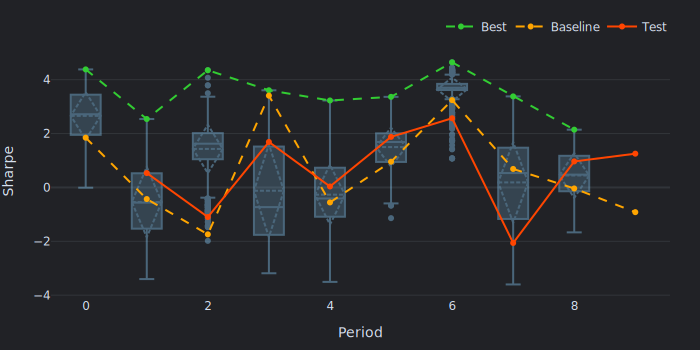

In [15]:
fig = is_perf.vbt.boxplot(
    by_level="period",
    trace_kwargs=dict(
        line=dict(color="lightskyblue"), 
        opacity=0.4,
        showlegend=False
    ),
    xaxis_title="Period", 
    yaxis_title="Sharpe",
)
fig = is_best_perf.vbt.select_levels("period").vbt.plot(
    trace_kwargs=dict(
        name="Best", 
        line=dict(color="limegreen", dash="dash")
    ), 
    fig=fig
)
fig = bl_perf.vbt.plot(
    trace_kwargs=dict(
        name="Baseline", 
        line=dict(color="orange", dash="dash")
    ), 
    fig=fig
)
fig = oos_perf.vbt.select_levels("period").vbt.plot(
    trace_kwargs=dict(
        name="Test", 
        line=dict(color="orangered")
    ), 
    fig=fig
)
fig.show_svg()

In [16]:
is_perf_split6 = is_perf.xs(6, level="split")
is_perf_split6.describe()

count    990.000000
mean       3.638821
std        0.441206
min        1.073553
25%        3.615566
50%        3.696611
75%        3.844124
max        4.644594
dtype: float64

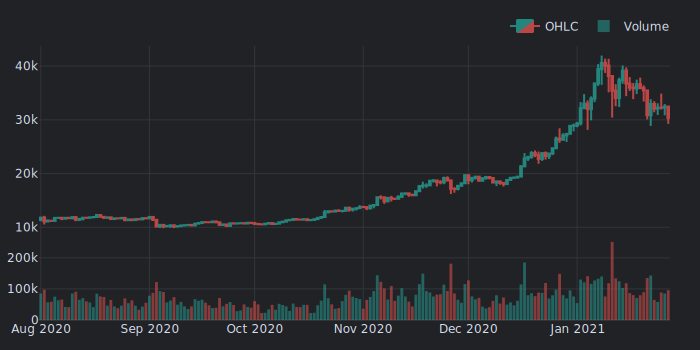

In [17]:
first_left_bound = period_ranges.loc[6, "start"]
first_right_bound = period_ranges.loc[6, "end"]
data[first_left_bound : first_right_bound].plot().show_svg()

In [18]:
oos_perf.xs(6, level="period")

split  fast_window  slow_window
5      20           27             2.567751
dtype: float64

In [19]:
is_perf_split6.quantile(0.25)

3.615566166097048

## Splitter

/home/jupyter/miniconda3/envs/vectorbtpro/lib/python3.10/site-packages/jupyter_client/session.py:721: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant

/home/jupyter/miniconda3/envs/vectorbtpro/lib/python3.10/site-packages/jupyter_client/session.py:721: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant



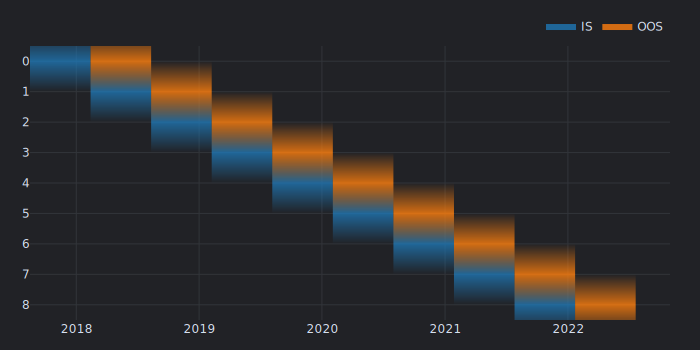

In [20]:
splitter = vbt.Splitter.from_rolling(
    data.index, 
    length=360, 
    split=0.5,
    set_labels=["IS", "OOS"]
)
splitter.plot().show_svg()

### Schema

In [21]:
print(splitter.splits)

set                         IS                      OOS
split                                                  
0          slice(0, 180, None)    slice(180, 360, None)
1        slice(180, 360, None)    slice(360, 540, None)
2        slice(360, 540, None)    slice(540, 720, None)
3        slice(540, 720, None)    slice(720, 900, None)
4        slice(720, 900, None)   slice(900, 1080, None)
5       slice(900, 1080, None)  slice(1080, 1260, None)
6      slice(1080, 1260, None)  slice(1260, 1440, None)
7      slice(1260, 1440, None)  slice(1440, 1620, None)
8      slice(1440, 1620, None)  slice(1620, 1800, None)


In [22]:
splitter.index

DatetimeIndex(['2017-08-17 00:00:00+00:00', '2017-08-18 00:00:00+00:00',
               '2017-08-19 00:00:00+00:00', '2017-08-20 00:00:00+00:00',
               '2017-08-21 00:00:00+00:00', '2017-08-22 00:00:00+00:00',
               '2017-08-23 00:00:00+00:00', '2017-08-24 00:00:00+00:00',
               '2017-08-25 00:00:00+00:00', '2017-08-26 00:00:00+00:00',
               ...
               '2022-10-22 00:00:00+00:00', '2022-10-23 00:00:00+00:00',
               '2022-10-24 00:00:00+00:00', '2022-10-25 00:00:00+00:00',
               '2022-10-26 00:00:00+00:00', '2022-10-27 00:00:00+00:00',
               '2022-10-28 00:00:00+00:00', '2022-10-29 00:00:00+00:00',
               '2022-10-30 00:00:00+00:00', '2022-10-31 00:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='Open time', length=1902, freq='D')

In [23]:
splitter.wrapper.index

RangeIndex(start=0, stop=9, step=1, name='split')

In [24]:
splitter.wrapper.columns

Index(['IS', 'OOS'], dtype='object', name='set')

In [25]:
oos_splitter = splitter["OOS"]
print(oos_splitter.splits)

split
0      slice(180, 360, None)
1      slice(360, 540, None)
2      slice(540, 720, None)
3      slice(720, 900, None)
4     slice(900, 1080, None)
5    slice(1080, 1260, None)
6    slice(1260, 1440, None)
7    slice(1440, 1620, None)
8    slice(1620, 1800, None)
Name: OOS, dtype: object


#### Range format

In [26]:
index = vbt.date_range("2020", periods=14)
index[slice(1, 7)]

DatetimeIndex(['2020-01-02', '2020-01-03', '2020-01-04', '2020-01-05',
               '2020-01-06', '2020-01-07'],
              dtype='datetime64[ns]', freq='D')

In [27]:
index[1], index[6]

(Timestamp('2020-01-02 00:00:00'), Timestamp('2020-01-07 00:00:00'))

##### Relative

In [28]:
rel_range = vbt.RelRange(offset=10, length=40)
rel_range

RelRange(offset=10, offset_anchor='prev_end', offset_space='free', length=40, length_space='free', out_of_bounds='warn', is_gap=False)

In [29]:
rel_range.to_slice(total_len=len(splitter.index), prev_end=100)

slice(110, 150, None)

#### Array format

In [30]:
index = vbt.date_range("2020", "2021", freq="1min")
range_ = np.arange(len(index))
range_.nbytes / 1024 / 1024

4.02099609375

In [31]:
range_ = np.full(len(index), True)
range_.nbytes / 1024 / 1024

0.50262451171875

In [32]:
splitter.splits_arr.dtype

dtype('O')

In [33]:
id(slice(0, 180, None))

139891035308736

In [34]:
range_00 = np.arange(0, 5)
range_01 = np.arange(5, 15)
range_10 = np.arange(15, 30)
range_11 = np.arange(30, 50)

ind_splitter = vbt.Splitter.from_splits(
    data.index,
    [[range_00, range_01], [range_10, range_11]],
    fix_ranges=False
)
print(ind_splitter.splits)

set                                                set_0  \
split                                                      
0                FixRange(range_=array([0, 1, 2, 3, 4]))   
1      FixRange(range_=array([15, 16, 17, 18, 19, 20,...   

set                                                set_1  
split                                                     
0      FixRange(range_=array([ 5,  6,  7,  8,  9, 10,...  
1      FixRange(range_=array([30, 31, 32, 33, 34, 35,...  


In [35]:
ind_splitter.splits.loc[0, "set_1"]

FixRange(range_=array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14]))

In [36]:
ind_splitter.splits.loc[0, "set_1"].range_

array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

### Preparation

#### Splits

In [37]:
vbt.Splitter.split_range(
    slice(None),
    (vbt.RelRange(length=0.75), vbt.RelRange()),
    index=data.index
)

(slice(0, 1426, None), slice(1426, 1902, None))

In [38]:
splitter.split_range(
    slice(None),
    (vbt.RelRange(length=0.75), vbt.RelRange())
)

(slice(0, 1426, None), slice(1426, 1902, None))

In [39]:
data[slice(0, 1426, None)]

In [40]:
vbt.Splitter.split_range(
    slice(None), 
    0.75, 
    index=data.index
)

(slice(0, 1426, None), slice(1426, 1902, None))

In [41]:
vbt.Splitter.split_range(
    slice(None), 
    -0.25,
    index=data.index
)

(slice(0, 1427, None), slice(1427, 1902, None))

In [42]:
int(0.75 * len(data.index))

1426

In [43]:
len(data.index) - int(0.25 * len(data.index))

1427

In [44]:
vbt.Splitter.split_range(
    slice(None), 
    (vbt.RelRange(), vbt.RelRange(length=0.25)),
    backwards=True,
    index=data.index
)

(slice(0, 1427, None), slice(1427, 1902, None))

In [45]:
vbt.Splitter.split_range(
    slice(None), 
    (1.0, 30), 
    backwards=True,
    index=data.index
)

(slice(0, 1872, None), slice(1872, 1902, None))

In [46]:
vbt.Splitter.split_range(
    slice(None), 
    (
        vbt.RelRange(length=0.4, length_space="all"), 
        vbt.RelRange(length=0.4, length_space="all"),
        vbt.RelRange()
    ),
    index=data.index
)

(slice(0, 760, None), slice(760, 1520, None), slice(1520, 1902, None))

In [47]:
vbt.Splitter.split_range(
    slice(None),
    (vbt.RelRange(length=0.75), vbt.RelRange(offset=1)),
    index=data.index
)

(slice(0, 1426, None), slice(1427, 1902, None))

In [48]:
vbt.Splitter.split_range(
    slice(None), 
    (
        vbt.RelRange(length=0.75), 
        vbt.RelRange(length=1, is_gap=True),
        vbt.RelRange()
    ),
    index=data.index
)

(slice(0, 1426, None), slice(1427, 1902, None))

In [49]:
vbt.Splitter.split_range(
    slice(None), 
    (np.array([3, 4, 5]), np.array([6, 8, 10])),
    index=data.index
)

(slice(3, 6, None), array([ 6,  8, 10]))

In [50]:
vbt.Splitter.split_range(
    slice(None), 
    (np.array([3, 4, 5]), np.array([6, 8, 10])),
    range_format="indices",
    index=data.index
)

(array([3, 4, 5]), array([ 6,  8, 10]))

In [51]:
vbt.Splitter.split_range(
    slice(None), 
    (slice("2020", "2021"), slice("2021", "2022")),
    index=data.index
)

(slice(867, 1233, None), slice(1233, 1598, None))

In [52]:
data.index[867:1233]

DatetimeIndex(['2020-01-01 00:00:00+00:00', '2020-01-02 00:00:00+00:00',
               '2020-01-03 00:00:00+00:00', '2020-01-04 00:00:00+00:00',
               '2020-01-05 00:00:00+00:00', '2020-01-06 00:00:00+00:00',
               '2020-01-07 00:00:00+00:00', '2020-01-08 00:00:00+00:00',
               '2020-01-09 00:00:00+00:00', '2020-01-10 00:00:00+00:00',
               ...
               '2020-12-22 00:00:00+00:00', '2020-12-23 00:00:00+00:00',
               '2020-12-24 00:00:00+00:00', '2020-12-25 00:00:00+00:00',
               '2020-12-26 00:00:00+00:00', '2020-12-27 00:00:00+00:00',
               '2020-12-28 00:00:00+00:00', '2020-12-29 00:00:00+00:00',
               '2020-12-30 00:00:00+00:00', '2020-12-31 00:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='Open time', length=366, freq='D')

In [53]:
data.index[1233:1598]

DatetimeIndex(['2021-01-01 00:00:00+00:00', '2021-01-02 00:00:00+00:00',
               '2021-01-03 00:00:00+00:00', '2021-01-04 00:00:00+00:00',
               '2021-01-05 00:00:00+00:00', '2021-01-06 00:00:00+00:00',
               '2021-01-07 00:00:00+00:00', '2021-01-08 00:00:00+00:00',
               '2021-01-09 00:00:00+00:00', '2021-01-10 00:00:00+00:00',
               ...
               '2021-12-22 00:00:00+00:00', '2021-12-23 00:00:00+00:00',
               '2021-12-24 00:00:00+00:00', '2021-12-25 00:00:00+00:00',
               '2021-12-26 00:00:00+00:00', '2021-12-27 00:00:00+00:00',
               '2021-12-28 00:00:00+00:00', '2021-12-29 00:00:00+00:00',
               '2021-12-30 00:00:00+00:00', '2021-12-31 00:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='Open time', length=365, freq='D')

In [54]:
vbt.Splitter.split_range(
    slice(None), 
    (
        vbt.RelRange(length="180 days"), 
        vbt.RelRange(offset="1 day", length="90 days")
    ),
    index=data.index
)

(slice(0, 180, None), slice(181, 271, None))

#### Method

In [55]:
manual_splitter = vbt.Splitter.from_splits(
    data.index,
    [
        (vbt.RelRange(), vbt.RelRange(offset=0.5, length=0.25, length_space="all")),
        (vbt.RelRange(), vbt.RelRange(offset=0.25, length=0.25, length_space="all")),
        (vbt.RelRange(), vbt.RelRange(offset=0, length=0.25, length_space="all")),
    ],
    split_range_kwargs=dict(backwards=True),
    set_labels=["IS", "OOS"]
)
print(manual_splitter.splits)

set                      IS                      OOS
split                                               
0       slice(0, 476, None)    slice(476, 951, None)
1       slice(0, 952, None)   slice(952, 1427, None)
2      slice(0, 1427, None)  slice(1427, 1902, None)


/home/jupyter/miniconda3/envs/vectorbtpro/lib/python3.10/site-packages/jupyter_client/session.py:721: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant

/home/jupyter/miniconda3/envs/vectorbtpro/lib/python3.10/site-packages/jupyter_client/session.py:721: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant



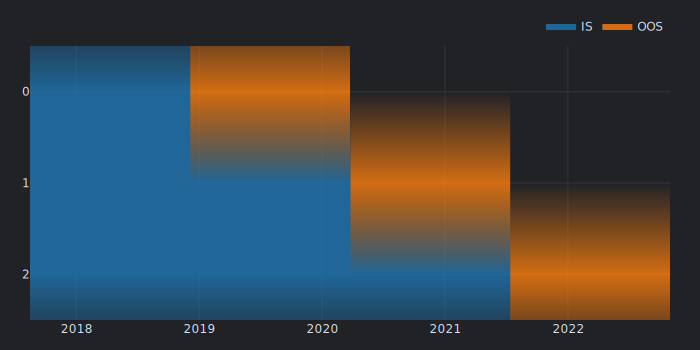

In [56]:
manual_splitter.plot().show_svg()

### Generation

#### Rolling

/home/jupyter/miniconda3/envs/vectorbtpro/lib/python3.10/site-packages/jupyter_client/session.py:721: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant



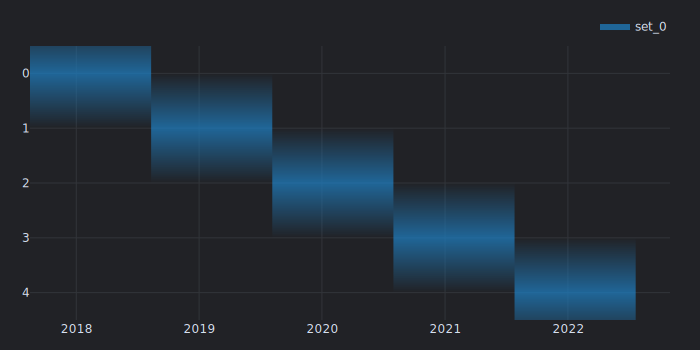

In [57]:
vbt.Splitter.from_rolling(
    data.index,
    length=360,
).plot().show_svg()

/home/jupyter/miniconda3/envs/vectorbtpro/lib/python3.10/site-packages/jupyter_client/session.py:721: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant



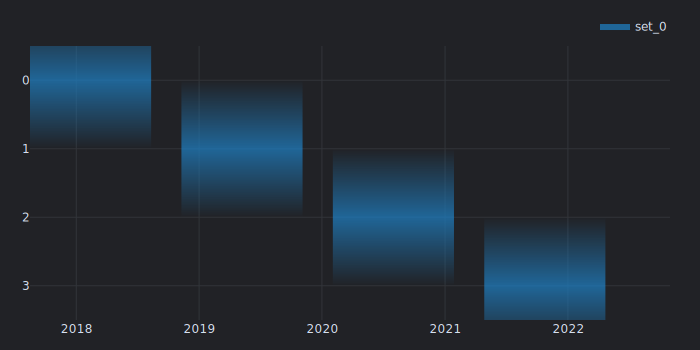

In [58]:
vbt.Splitter.from_rolling(
    data.index, 
    length=360,
    offset=90
).plot().show_svg()

/home/jupyter/miniconda3/envs/vectorbtpro/lib/python3.10/site-packages/jupyter_client/session.py:721: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant



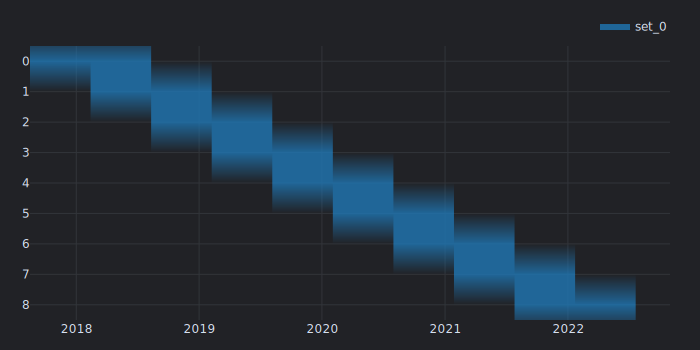

In [59]:
vbt.Splitter.from_rolling(
    data.index, 
    length=360,
    offset=-0.5
).plot().show_svg()

/home/jupyter/miniconda3/envs/vectorbtpro/lib/python3.10/site-packages/jupyter_client/session.py:721: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant

/home/jupyter/miniconda3/envs/vectorbtpro/lib/python3.10/site-packages/jupyter_client/session.py:721: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant



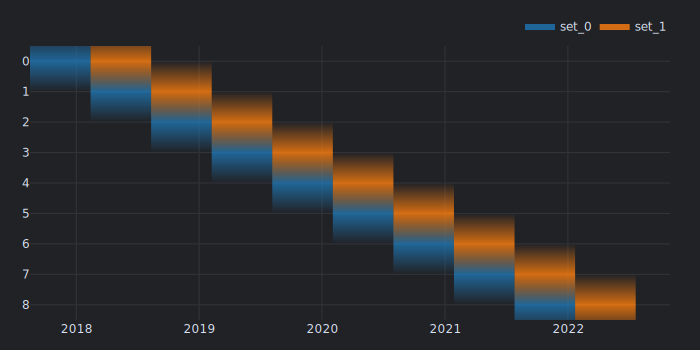

In [60]:
vbt.Splitter.from_rolling(
    data.index, 
    length=360,
    split=0.5
).plot().show_svg()

/home/jupyter/miniconda3/envs/vectorbtpro/lib/python3.10/site-packages/jupyter_client/session.py:721: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant

/home/jupyter/miniconda3/envs/vectorbtpro/lib/python3.10/site-packages/jupyter_client/session.py:721: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant



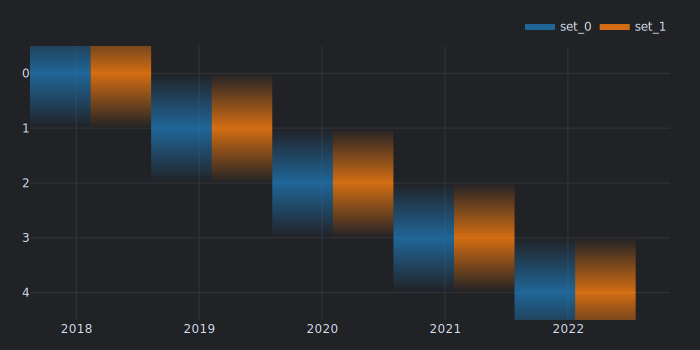

In [61]:
vbt.Splitter.from_rolling(
    data.index,
    length=360,
    split=0.5,
    offset_anchor_set=None
).plot().show_svg()

/home/jupyter/miniconda3/envs/vectorbtpro/lib/python3.10/site-packages/jupyter_client/session.py:721: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant

/home/jupyter/miniconda3/envs/vectorbtpro/lib/python3.10/site-packages/jupyter_client/session.py:721: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant



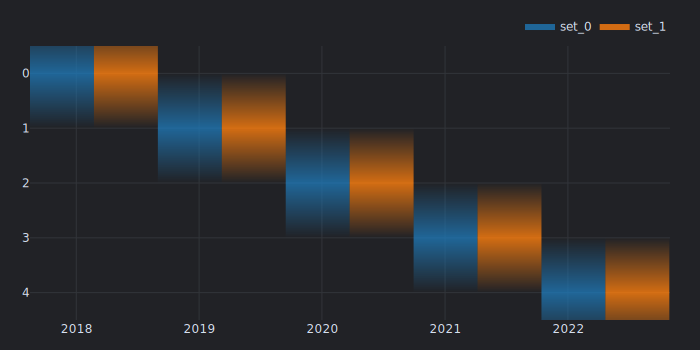

In [62]:
vbt.Splitter.from_n_rolling(
    data.index,
    n=5,
    split=0.5
).plot().show_svg()

/home/jupyter/miniconda3/envs/vectorbtpro/lib/python3.10/site-packages/jupyter_client/session.py:721: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant

/home/jupyter/miniconda3/envs/vectorbtpro/lib/python3.10/site-packages/jupyter_client/session.py:721: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant



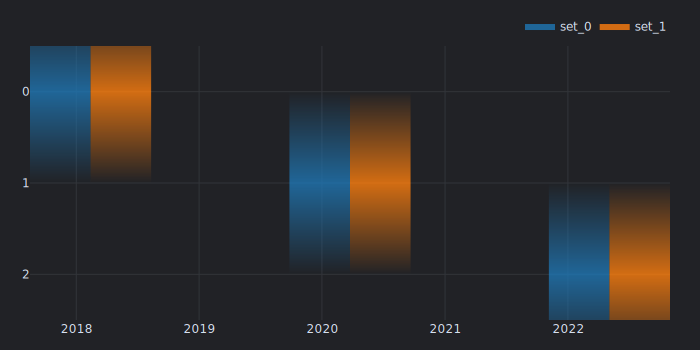

In [63]:
vbt.Splitter.from_n_rolling(
    data.index,
    n=3,
    length=360,
    split=0.5
).plot().show_svg()

/home/jupyter/miniconda3/envs/vectorbtpro/lib/python3.10/site-packages/jupyter_client/session.py:721: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant

/home/jupyter/miniconda3/envs/vectorbtpro/lib/python3.10/site-packages/jupyter_client/session.py:721: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant



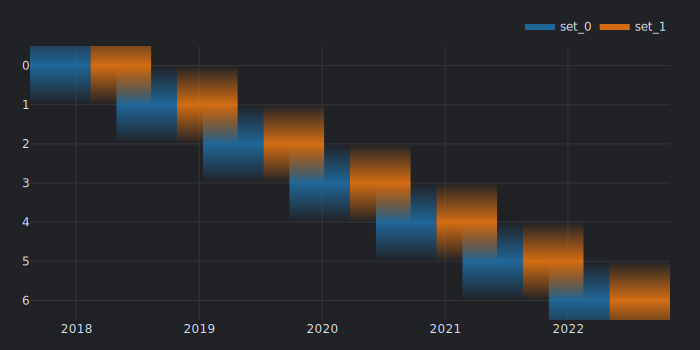

In [64]:
vbt.Splitter.from_n_rolling(
    data.index,
    n=7,
    length=360,
    split=0.5
).plot().show_svg()

/home/jupyter/miniconda3/envs/vectorbtpro/lib/python3.10/site-packages/jupyter_client/session.py:721: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant

/home/jupyter/miniconda3/envs/vectorbtpro/lib/python3.10/site-packages/jupyter_client/session.py:721: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant



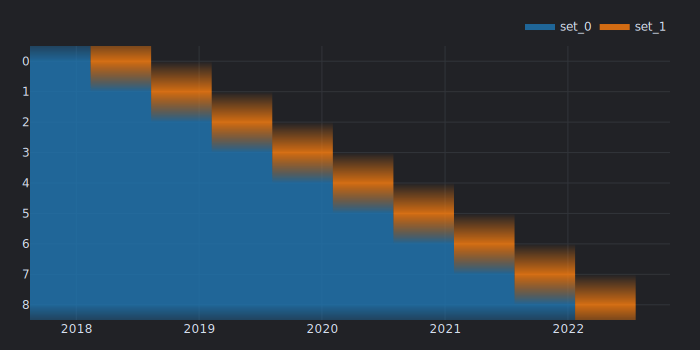

In [65]:
vbt.Splitter.from_expanding(
    data.index, 
    min_length=360,
    offset=180,
    split=-180
).plot().show_svg()

/home/jupyter/miniconda3/envs/vectorbtpro/lib/python3.10/site-packages/jupyter_client/session.py:721: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant

/home/jupyter/miniconda3/envs/vectorbtpro/lib/python3.10/site-packages/jupyter_client/session.py:721: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant



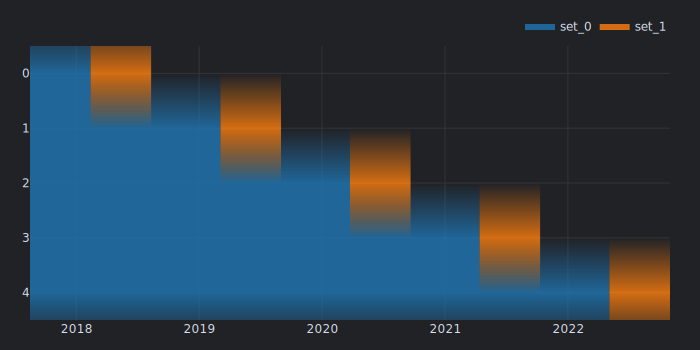

In [66]:
vbt.Splitter.from_n_expanding(
    data.index, 
    n=5,
    min_length=360,
    split=-180
).plot().show_svg()

#### Anchored

/home/jupyter/miniconda3/envs/vectorbtpro/lib/python3.10/site-packages/jupyter_client/session.py:721: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant

/home/jupyter/miniconda3/envs/vectorbtpro/lib/python3.10/site-packages/jupyter_client/session.py:721: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant



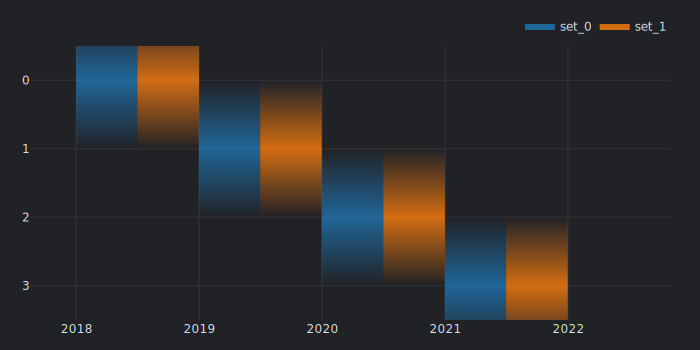

In [67]:
vbt.Splitter.from_ranges(
    data.index,
    every="Y",
    split=0.5
).plot().show_svg()

/home/jupyter/miniconda3/envs/vectorbtpro/lib/python3.10/site-packages/jupyter_client/session.py:721: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant

/home/jupyter/miniconda3/envs/vectorbtpro/lib/python3.10/site-packages/jupyter_client/session.py:721: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant



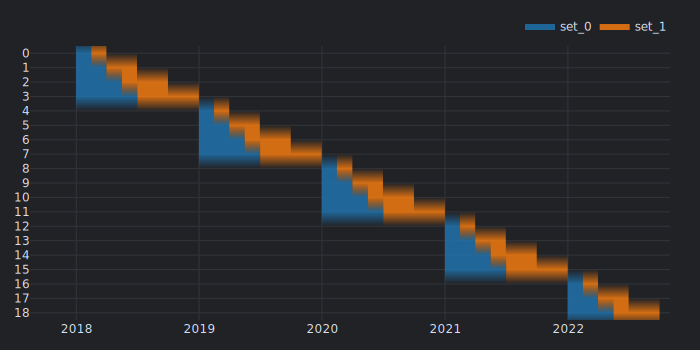

In [68]:
vbt.Splitter.from_ranges(
    data.index,
    every="Q",
    lookback_period="Y",
    split=0.5
).plot().show_svg()

/home/jupyter/miniconda3/envs/vectorbtpro/lib/python3.10/site-packages/jupyter_client/session.py:721: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant

/home/jupyter/miniconda3/envs/vectorbtpro/lib/python3.10/site-packages/jupyter_client/session.py:721: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant



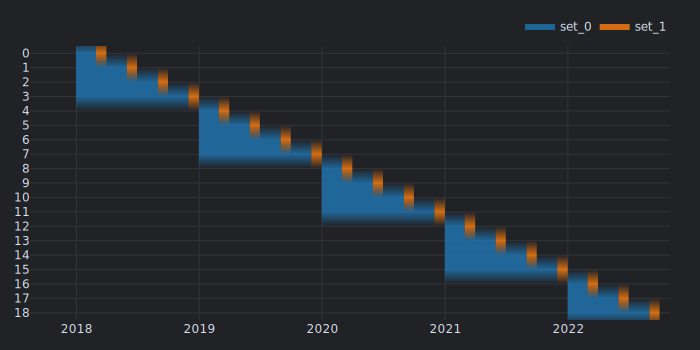

In [69]:
vbt.Splitter.from_ranges(
    data.index,
    every="Q",
    lookback_period="Y",
    split=(
        vbt.RepEval("index.month != index.month[-1]"),
        vbt.RepEval("index.month == index.month[-1]")
    )
).plot().show_svg()

/tmp/ipykernel_433292/1879835424.py:2: UserWarning:

Converting to PeriodArray/Index representation will drop timezone information.

/home/jupyter/miniconda3/envs/vectorbtpro/lib/python3.10/site-packages/jupyter_client/session.py:721: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant

/home/jupyter/miniconda3/envs/vectorbtpro/lib/python3.10/site-packages/jupyter_client/session.py:721: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant



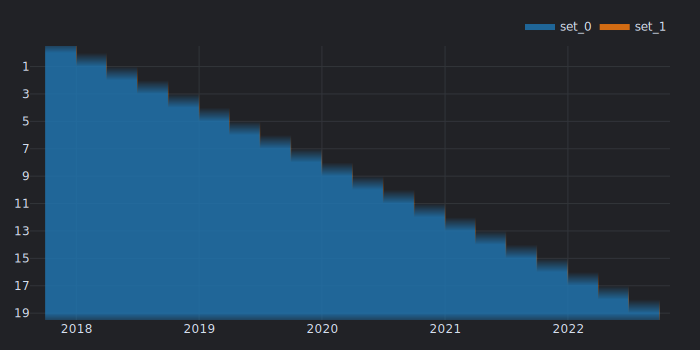

In [70]:
def qyear(index):
    return index.to_period("Q")

vbt.Splitter.from_ranges(
    data.index,
    start=0,
    fixed_start=True,
    every="Q",
    closed_end=True,
    split=(
        lambda index: qyear(index) != qyear(index)[-1],
        lambda index: qyear(index) == qyear(index)[-1]
    )
).plot().show_svg()

/home/jupyter/miniconda3/envs/vectorbtpro/lib/python3.10/site-packages/jupyter_client/session.py:721: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant

/home/jupyter/miniconda3/envs/vectorbtpro/lib/python3.10/site-packages/jupyter_client/session.py:721: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant



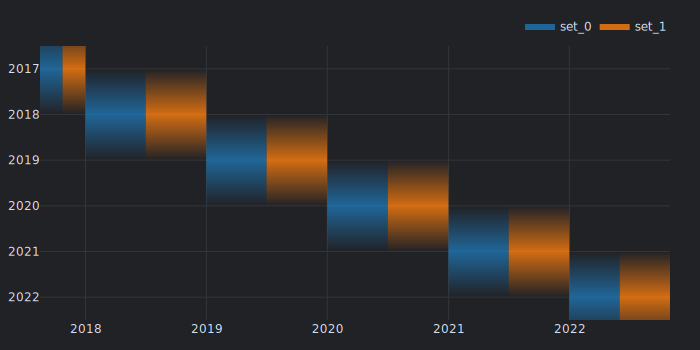

In [71]:
vbt.Splitter.from_grouper(
    data.index,
    by="Y",
    split=0.5
).plot().show_svg()

/home/jupyter/miniconda3/envs/vectorbtpro/lib/python3.10/site-packages/jupyter_client/session.py:721: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant

/home/jupyter/miniconda3/envs/vectorbtpro/lib/python3.10/site-packages/jupyter_client/session.py:721: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant



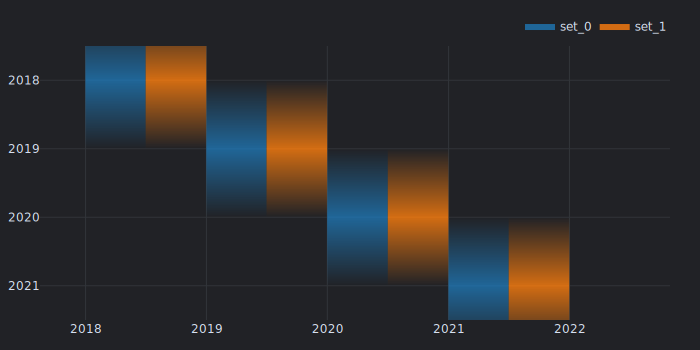

In [72]:
def is_split_complete(index, split):
    first_range = split[0]
    first_index = index[first_range][0]
    last_range = split[-1]
    last_index = index[last_range][-1]
    return first_index.is_year_start and last_index.is_year_end

vbt.Splitter.from_grouper(
    data.index,
    by="Y",
    split=0.5,
    split_check_template=vbt.RepFunc(is_split_complete)
).plot().show_svg()

/home/jupyter/miniconda3/envs/vectorbtpro/lib/python3.10/site-packages/jupyter_client/session.py:721: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant

/home/jupyter/miniconda3/envs/vectorbtpro/lib/python3.10/site-packages/jupyter_client/session.py:721: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant



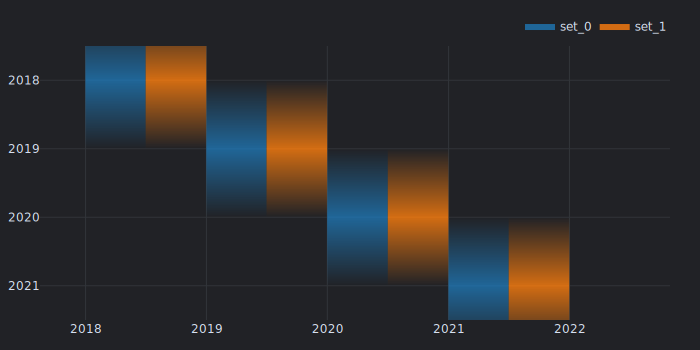

In [73]:
def format_split_labels(index, splits_arr):
    years = map(lambda x: index[x[0]][0].year, splits_arr)
    return pd.Index(years, name="split_year")

vbt.Splitter.from_grouper(
    data.index,
    by="Y",
    split=0.5,
    split_check_template=vbt.RepFunc(is_split_complete),
    split_labels=vbt.RepFunc(format_split_labels)
).plot().show_svg()

/home/jupyter/miniconda3/envs/vectorbtpro/lib/python3.10/site-packages/jupyter_client/session.py:721: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant

/home/jupyter/miniconda3/envs/vectorbtpro/lib/python3.10/site-packages/jupyter_client/session.py:721: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant



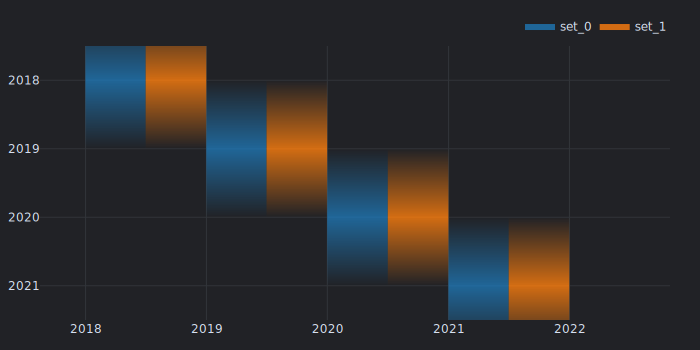

In [74]:
vbt.Splitter.from_grouper(
    data.index,
    by=data.index.year,
    split=0.5,
    split_check_template=vbt.RepFunc(is_split_complete)
).plot().show_svg()

#### Random

/home/jupyter/miniconda3/envs/vectorbtpro/lib/python3.10/site-packages/jupyter_client/session.py:721: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant

/home/jupyter/miniconda3/envs/vectorbtpro/lib/python3.10/site-packages/jupyter_client/session.py:721: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant



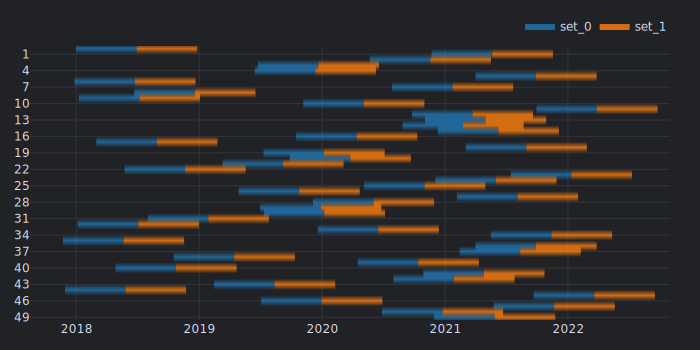

In [75]:
vbt.Splitter.from_n_random(
    data.index,
    n=50,
    min_length=360,
    seed=42,
    split=0.5
).plot().show_svg()

/home/jupyter/miniconda3/envs/vectorbtpro/lib/python3.10/site-packages/jupyter_client/session.py:721: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant

/home/jupyter/miniconda3/envs/vectorbtpro/lib/python3.10/site-packages/jupyter_client/session.py:721: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant



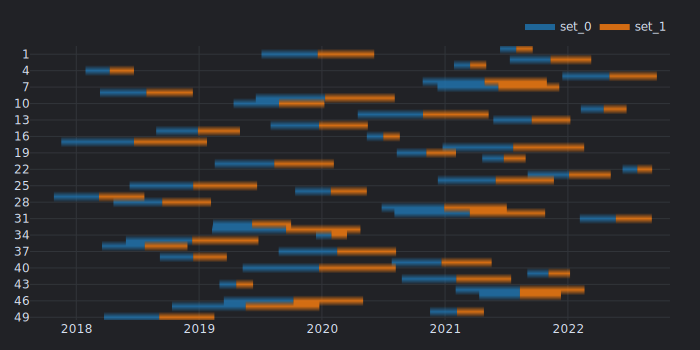

In [76]:
vbt.Splitter.from_n_random(
    data.index,
    n=50,
    min_length=60,
    max_length=480,
    seed=42,
    split=0.5
).plot().show_svg()

/home/jupyter/miniconda3/envs/vectorbtpro/lib/python3.10/site-packages/jupyter_client/session.py:721: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant

/home/jupyter/miniconda3/envs/vectorbtpro/lib/python3.10/site-packages/jupyter_client/session.py:721: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant



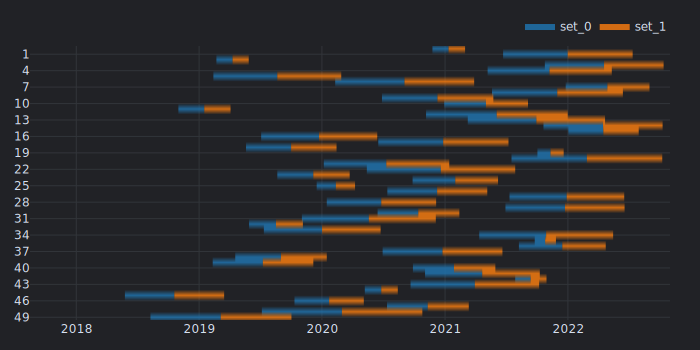

In [77]:
def start_p_func(i, indices):
    return indices / indices.sum()

vbt.Splitter.from_n_random(
    data.index,
    n=50,
    min_length=60,
    max_length=480,
    seed=42,
    start_p_func=start_p_func,
    split=0.5
).plot().show_svg()

#### Scikit-learn

/home/jupyter/miniconda3/envs/vectorbtpro/lib/python3.10/site-packages/jupyter_client/session.py:721: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant

/home/jupyter/miniconda3/envs/vectorbtpro/lib/python3.10/site-packages/jupyter_client/session.py:721: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant



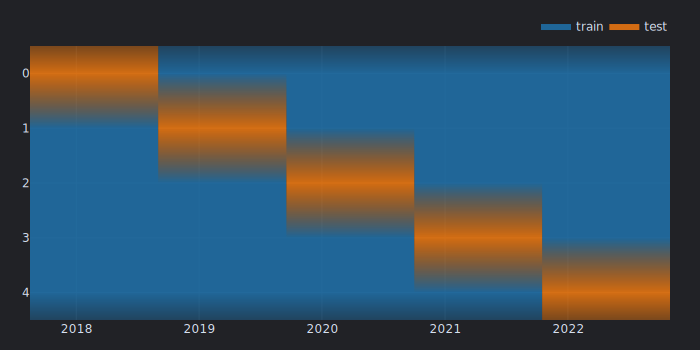

In [78]:
from sklearn.model_selection import KFold

vbt.Splitter.from_sklearn(
    data.index, 
    KFold(n_splits=5)
).plot().show_svg()

#### Dynamic

/home/jupyter/miniconda3/envs/vectorbtpro/lib/python3.10/site-packages/jupyter_client/session.py:721: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant

/home/jupyter/miniconda3/envs/vectorbtpro/lib/python3.10/site-packages/jupyter_client/session.py:721: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant



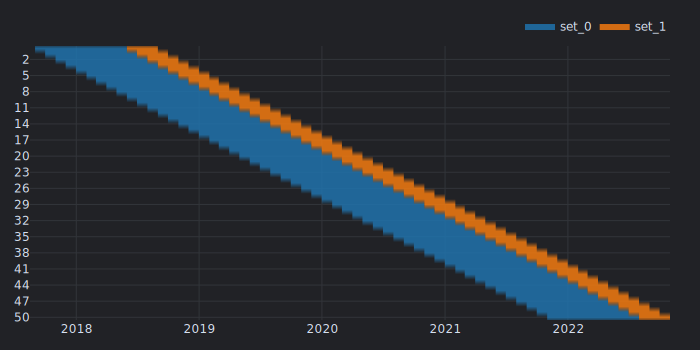

In [79]:
def split_func(index, prev_start):
    if prev_start is None:
        prev_start = index[0]
    new_start = prev_start + pd.offsets.MonthBegin(1)
    new_end = new_start + pd.DateOffset(years=1)
    if new_end > index[-1] + index.freq:
        return None
    return [
        slice(new_start, new_start + pd.offsets.MonthBegin(9)),
        slice(new_start + pd.offsets.MonthBegin(9), new_end)
    ]

vbt.Splitter.from_split_func(
    data.index,
    split_func=split_func,
    split_args=(vbt.Rep("index"), vbt.Rep("prev_start")),
    range_bounds_kwargs=dict(index_bounds=True)
).plot().show_svg()

/home/jupyter/miniconda3/envs/vectorbtpro/lib/python3.10/site-packages/jupyter_client/session.py:721: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant

/home/jupyter/miniconda3/envs/vectorbtpro/lib/python3.10/site-packages/jupyter_client/session.py:721: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant



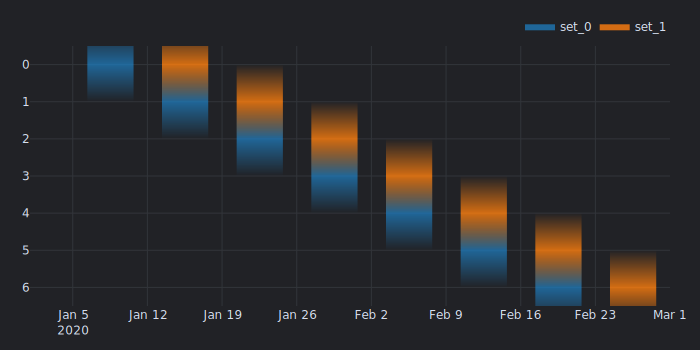

In [80]:
def get_next_monday(from_date):
    if from_date.weekday == 0 and from_date.ceil("H").hour <= 9:
        return from_date.floor("D")
    return from_date.floor("D") + pd.offsets.Week(n=0, weekday=0)

def get_next_business_range(from_date):
    monday_0000 = get_next_monday(from_date)
    monday_0900 = monday_0000 + pd.DateOffset(hours=9)
    friday_1700 = monday_0900 + pd.DateOffset(days=4, hours=8)
    return slice(monday_0900, friday_1700)

def split_func(index, bounds):
    if len(bounds) == 0:
        from_date = index[0]
    else:
        from_date = bounds[-1][1][0]
    train_range = get_next_business_range(from_date)
    test_range = get_next_business_range(train_range.stop)
    if test_range.stop > index[-1] + index.freq:
        return None
    return train_range, test_range

vbt.Splitter.from_split_func(
    vbt.date_range("2020-01", "2020-03", freq="15min"),
    split_func=split_func,
    split_args=(vbt.Rep("index"), vbt.Rep("bounds")),
    range_bounds_kwargs=dict(index_bounds=True)
).plot().show_svg()

### Validation

/home/jupyter/miniconda3/envs/vectorbtpro/lib/python3.10/site-packages/jupyter_client/session.py:721: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant

/home/jupyter/miniconda3/envs/vectorbtpro/lib/python3.10/site-packages/jupyter_client/session.py:721: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant



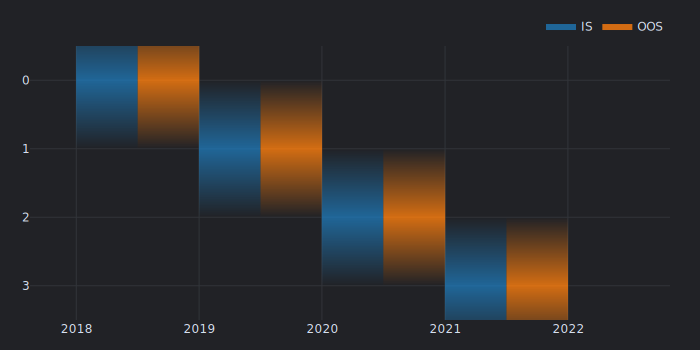

In [81]:
splitter = vbt.Splitter.from_ranges(
    data.index,
    every="Y",
    closed_end=True,
    split=0.5,
    set_labels=["IS", "OOS"]
)
splitter.plot().show_svg()

#### Bounds

In [82]:
bounds_arr = splitter.get_bounds_arr()
bounds_arr.shape

(4, 2, 2)

In [83]:
print(bounds_arr)

[[[ 137  320]
  [ 320  503]]

 [[ 502  685]
  [ 685  868]]

 [[ 867 1050]
  [1050 1234]]

 [[1233 1416]
  [1416 1599]]]


In [84]:
bounds = splitter.get_bounds(index_bounds=True)
bounds.shape

(8, 2)

In [85]:
print(bounds)

bound                         start                       end
split set                                                    
0     IS  2018-01-01 00:00:00+00:00 2018-07-03 00:00:00+00:00
      OOS 2018-07-03 00:00:00+00:00 2019-01-02 00:00:00+00:00
1     IS  2019-01-01 00:00:00+00:00 2019-07-03 00:00:00+00:00
      OOS 2019-07-03 00:00:00+00:00 2020-01-02 00:00:00+00:00
2     IS  2020-01-01 00:00:00+00:00 2020-07-02 00:00:00+00:00
      OOS 2020-07-02 00:00:00+00:00 2021-01-02 00:00:00+00:00
3     IS  2021-01-01 00:00:00+00:00 2021-07-03 00:00:00+00:00
      OOS 2021-07-03 00:00:00+00:00 2022-01-02 00:00:00+00:00


In [86]:
bounds.loc[(0, "OOS"), "end"]

Timestamp('2019-01-02 00:00:00+0000', tz='UTC')

In [87]:
bounds.loc[(1, "IS"), "start"]

Timestamp('2019-01-01 00:00:00+0000', tz='UTC')

#### Masks

In [88]:
mask = splitter.get_mask()
mask.shape

(1902, 8)

In [89]:
print(mask)

split                          0             1             2             3  \
set                           IS    OOS     IS    OOS     IS    OOS     IS   
Open time                                                                    
2017-08-17 00:00:00+00:00  False  False  False  False  False  False  False   
2017-08-18 00:00:00+00:00  False  False  False  False  False  False  False   
2017-08-19 00:00:00+00:00  False  False  False  False  False  False  False   
2017-08-20 00:00:00+00:00  False  False  False  False  False  False  False   
2017-08-21 00:00:00+00:00  False  False  False  False  False  False  False   
...                          ...    ...    ...    ...    ...    ...    ...   
2022-10-27 00:00:00+00:00  False  False  False  False  False  False  False   
2022-10-28 00:00:00+00:00  False  False  False  False  False  False  False   
2022-10-29 00:00:00+00:00  False  False  False  False  False  False  False   
2022-10-30 00:00:00+00:00  False  False  False  False  False  Fa

In [90]:
mask["2021":"2021"].any()

split  set
0      IS     False
       OOS    False
1      IS     False
       OOS    False
2      IS     False
       OOS     True
3      IS      True
       OOS     True
dtype: bool

In [92]:
print(mask.resample(vbt.offset("Y")).sum())

split                        0         1         2         3     
set                         IS  OOS   IS  OOS   IS  OOS   IS  OOS
Open time                                                        
2017-01-01 00:00:00+00:00    0    0    0    0    0    0    0    0
2018-01-01 00:00:00+00:00  183  182    0    0    0    0    0    0
2019-01-01 00:00:00+00:00    0    1  183  182    0    0    0    0
2020-01-01 00:00:00+00:00    0    0    0    1  183  183    0    0
2021-01-01 00:00:00+00:00    0    0    0    0    0    1  183  182
2022-01-01 00:00:00+00:00    0    0    0    0    0    0    0    1


In [94]:
results = []
for mask in splitter.get_iter_split_masks():
    results.append(mask.resample(vbt.offset("Y")).sum())
print(pd.concat(results, axis=1, keys=splitter.split_labels))

split                        0         1         2         3     
set                         IS  OOS   IS  OOS   IS  OOS   IS  OOS
Open time                                                        
2017-01-01 00:00:00+00:00    0    0    0    0    0    0    0    0
2018-01-01 00:00:00+00:00  183  182    0    0    0    0    0    0
2019-01-01 00:00:00+00:00    0    1  183  182    0    0    0    0
2020-01-01 00:00:00+00:00    0    0    0    1  183  183    0    0
2021-01-01 00:00:00+00:00    0    0    0    0    0    1  183  182
2022-01-01 00:00:00+00:00    0    0    0    0    0    0    0    1


#### Coverage

In [95]:
splitter.get_split_coverage()

split
0    0.192429
1    0.192429
2    0.192955
3    0.192429
Name: split_coverage, dtype: float64

In [96]:
splitter.get_set_coverage()

set
IS     0.384858
OOS    0.385384
Name: set_coverage, dtype: float64

In [97]:
splitter.get_range_coverage()

split  set
0      IS     0.096215
       OOS    0.096215
1      IS     0.096215
       OOS    0.096215
2      IS     0.096215
       OOS    0.096740
3      IS     0.096215
       OOS    0.096215
Name: range_coverage, dtype: float64

In [98]:
splitter.get_coverage()

0.768664563617245

In [99]:
splitter.index_bounds.loc[(2, "OOS"), "start"].is_leap_year

True

In [100]:
splitter.get_range_coverage(relative=True)

split  set
0      IS     0.500000
       OOS    0.500000
1      IS     0.500000
       OOS    0.500000
2      IS     0.498638
       OOS    0.501362
3      IS     0.500000
       OOS    0.500000
Name: range_coverage, dtype: float64

In [101]:
splitter.get_set_coverage(relative=True)

set
IS     0.500684
OOS    0.501368
Name: set_coverage, dtype: float64

In [102]:
splitter.get_split_coverage(overlapping=True)

split
0    0.0
1    0.0
2    0.0
3    0.0
Name: split_coverage, dtype: float64

In [103]:
splitter.get_set_coverage(overlapping=True)

set
IS     0.0
OOS    0.0
Name: set_coverage, dtype: float64

In [104]:
splitter.get_coverage(overlapping=True)

0.002051983584131327

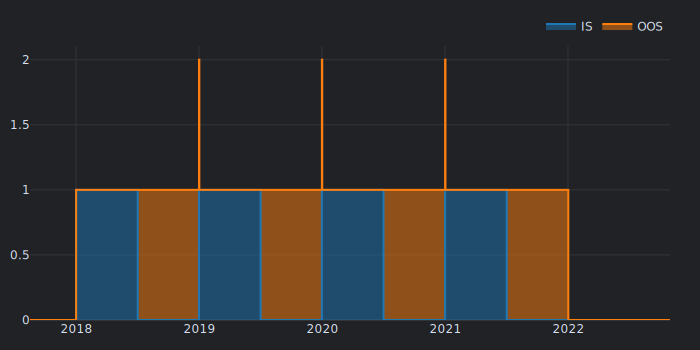

In [105]:
splitter.plot_coverage().show_svg()

In [106]:
print(splitter.get_overlap_matrix(by="range", normalize=False))

split        0         1         2         3     
set         IS  OOS   IS  OOS   IS  OOS   IS  OOS
split set                                        
0     IS   183    0    0    0    0    0    0    0
      OOS    0  183    1    0    0    0    0    0
1     IS     0    1  183    0    0    0    0    0
      OOS    0    0    0  183    1    0    0    0
2     IS     0    0    0    1  183    0    0    0
      OOS    0    0    0    0    0  184    1    0
3     IS     0    0    0    0    0    1  183    0
      OOS    0    0    0    0    0    0    0  183


#### Grouping

In [107]:
print(splitter.get_bounds(index_bounds=True, set_group_by=True))

bound                     start                       end
split                                                    
0     2018-01-01 00:00:00+00:00 2019-01-02 00:00:00+00:00
1     2019-01-01 00:00:00+00:00 2020-01-02 00:00:00+00:00
2     2020-01-01 00:00:00+00:00 2021-01-02 00:00:00+00:00
3     2021-01-01 00:00:00+00:00 2022-01-02 00:00:00+00:00


### Manipulation

In [108]:
splitter = vbt.Splitter.from_grouper(
    data.index, 
    by=data.index.year.rename("split_year")
)

In [109]:
splitter.stats()

Index Start             2017-08-17 00:00:00+00:00
Index End               2022-10-31 00:00:00+00:00
Index Length                                 1902
Splits                                          6
Sets                                            1
Coverage [%]                                100.0
Overlap Coverage [%]                          0.0
Name: agg_stats, dtype: object

/home/jupyter/miniconda3/envs/vectorbtpro/lib/python3.10/site-packages/jupyter_client/session.py:721: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant



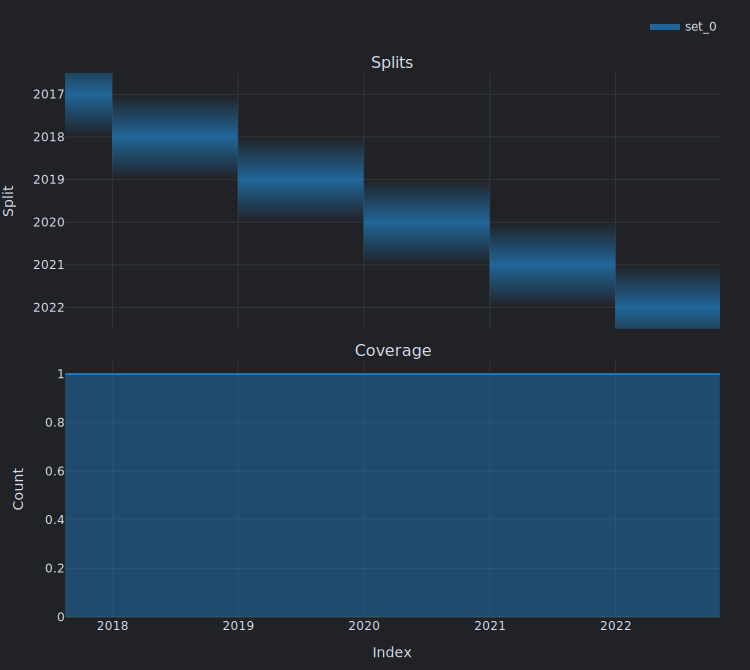

In [110]:
splitter.plots().show_svg()

In [111]:
splitter = splitter.iloc[1:-1]
splitter.stats()

Index Start             2017-08-17 00:00:00+00:00
Index End               2022-10-31 00:00:00+00:00
Index Length                                 1902
Splits                                          4
Sets                                            1
Coverage [%]                             76.81388
Overlap Coverage [%]                          0.0
Name: agg_stats, dtype: object

In [112]:
def new_split(index):
    return [
        np.isin(index.quarter, [1, 2]), 
        index.quarter == 3, 
        index.quarter == 4
    ]

splitter = splitter.split_set(
    vbt.RepFunc(new_split),
    new_set_labels=["train", "valid", "test"]
)

In [113]:
splitter.stats()

Index Start                     2017-08-17 00:00:00+00:00
Index End                       2022-10-31 00:00:00+00:00
Index Length                                         1902
Splits                                                  4
Sets                                                    3
Coverage [%]                                     76.81388
Coverage [%]: train                             38.117771
Coverage [%]: valid                             19.348055
Coverage [%]: test                              19.348055
Mean Rel Coverage [%]: train                    49.623475
Mean Rel Coverage [%]: valid                    25.188263
Mean Rel Coverage [%]: test                     25.188263
Overlap Coverage [%]                                  0.0
Overlap Coverage [%]: train                           0.0
Overlap Coverage [%]: valid                           0.0
Overlap Coverage [%]: test                            0.0
Name: agg_stats, dtype: object

/home/jupyter/miniconda3/envs/vectorbtpro/lib/python3.10/site-packages/jupyter_client/session.py:721: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant

/home/jupyter/miniconda3/envs/vectorbtpro/lib/python3.10/site-packages/jupyter_client/session.py:721: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant

/home/jupyter/miniconda3/envs/vectorbtpro/lib/python3.10/site-packages/jupyter_client/session.py:721: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant



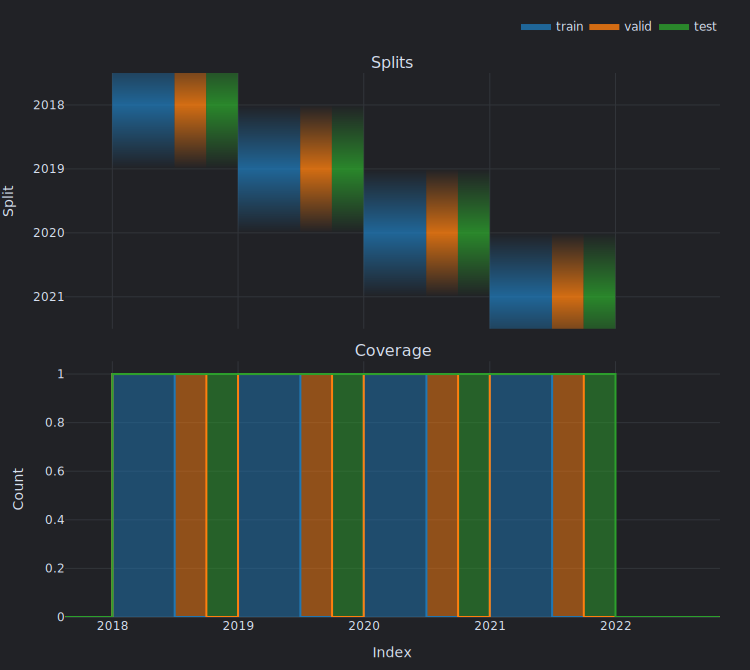

In [114]:
splitter.plots().show_svg()

#### Homework

/home/jupyter/miniconda3/envs/vectorbtpro/lib/python3.10/site-packages/jupyter_client/session.py:721: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant

/home/jupyter/miniconda3/envs/vectorbtpro/lib/python3.10/site-packages/jupyter_client/session.py:721: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant



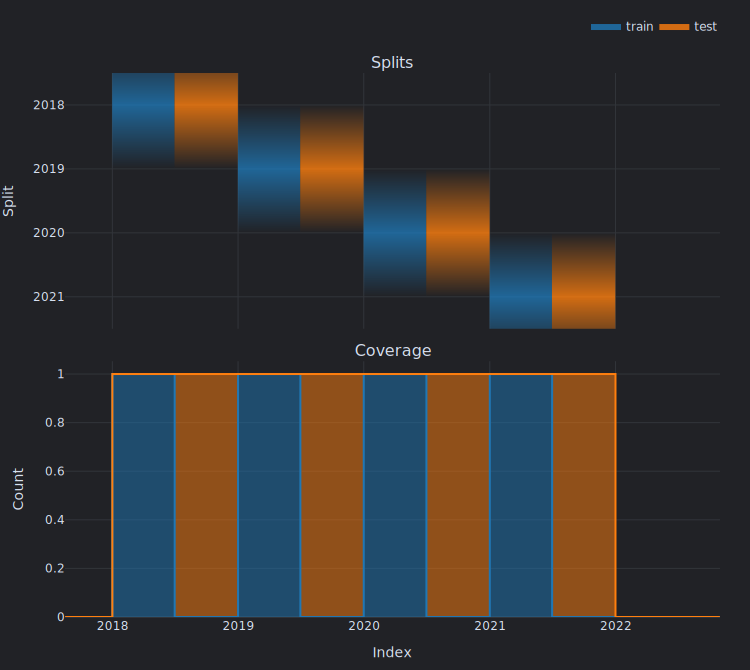

In [115]:
splitter = splitter.merge_sets(columns=["valid", "test"], new_set_label="test")
splitter.plots().show_svg()

## Applications

### Taking

#### Without stacking

In [116]:
close_slices = splitter.take(data.close)
close_slices

split_year  set  
2018        train    Open time
2018-01-01 00:00:00+00:00    13380.0...
            test     Open time
2018-07-01 00:00:00+00:00    6356.81...
2019        train    Open time
2019-01-01 00:00:00+00:00     3797.1...
            test     Open time
2019-07-01 00:00:00+00:00    10624.9...
2020        train    Open time
2020-01-01 00:00:00+00:00    7200.85...
            test     Open time
2020-07-01 00:00:00+00:00     9232.0...
2021        train    Open time
2021-01-01 00:00:00+00:00    29331.6...
            test     Open time
2021-07-01 00:00:00+00:00    33504.6...
dtype: object

In [117]:
close_slices[2020, "test"]

Open time
2020-07-01 00:00:00+00:00     9232.00
2020-07-02 00:00:00+00:00     9086.54
2020-07-03 00:00:00+00:00     9058.26
2020-07-04 00:00:00+00:00     9135.46
2020-07-05 00:00:00+00:00     9069.41
                               ...   
2020-12-27 00:00:00+00:00    26281.66
2020-12-28 00:00:00+00:00    27079.41
2020-12-29 00:00:00+00:00    27385.00
2020-12-30 00:00:00+00:00    28875.54
2020-12-31 00:00:00+00:00    28923.63
Freq: D, Name: Close, Length: 184, dtype: float64

In [118]:
def get_total_return(sr):
    return sr.vbt.to_returns().vbt.returns.total()

close_slices.apply(get_total_return)

split_year  set  
2018        train   -0.522416
            test    -0.417491
2019        train    1.858493
            test    -0.322797
2020        train    0.269093
            test     2.132976
2021        train    0.194783
            test     0.379417
dtype: float64

##### Complex objects

/home/jupyter/miniconda3/envs/vectorbtpro/lib/python3.10/site-packages/jupyter_client/session.py:721: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant



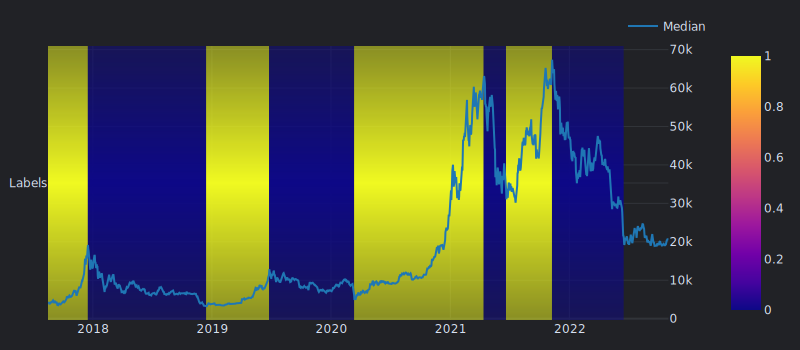

In [119]:
trendlb = data.run("trendlb", 1.0, 0.5)
trendlb.plot().show_svg()

/home/jupyter/miniconda3/envs/vectorbtpro/lib/python3.10/site-packages/jupyter_client/session.py:721: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant



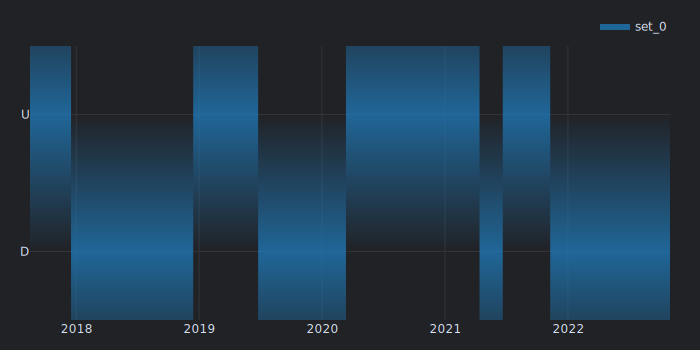

In [120]:
grouper = pd.Index(trendlb.labels.map({1: "U", 0: "D"}), name="trend")
trend_splitter = vbt.Splitter.from_grouper(data.index, grouper)
trend_splitter.plot().show_svg()

In [121]:
hold_pf = vbt.Portfolio.from_holding(data)
hold_returns_acc = hold_pf.returns_acc

fast_sma, slow_sma = vbt.talib("SMA").run_combs(
    data.close, np.arange(5, 50), short_names=["fast_sma", "slow_sma"])
entries = fast_sma.real_crossed_above(slow_sma)
exits = fast_sma.real_crossed_below(slow_sma)
strat_pf = vbt.Portfolio.from_signals(
    data, entries, exits, direction="both")
strat_returns_acc = strat_pf.returns_acc

In [122]:
hold_returns_acc_slices = trend_splitter.take(hold_returns_acc)
strat_returns_acc_slices = trend_splitter.take(strat_returns_acc)

In [123]:
hold_returns_acc_slices["U"].sharpe_ratio()

3.8722154610775616

/home/jupyter/miniconda3/envs/vectorbtpro/lib/python3.10/site-packages/jupyter_client/session.py:721: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant



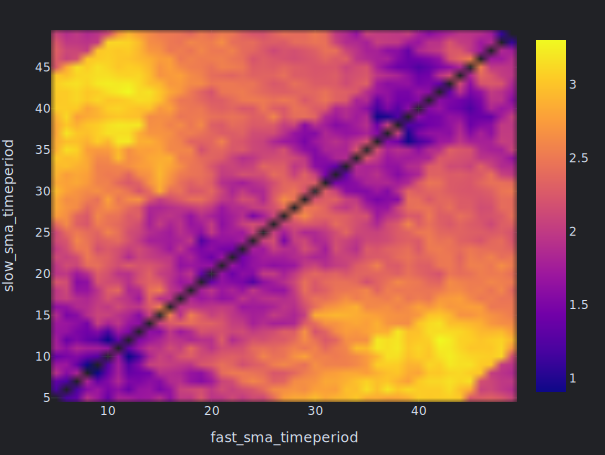

In [124]:
strat_returns_acc_slices["U"].sharpe_ratio().vbt.heatmap(
    x_level="fast_sma_timeperiod", 
    y_level="slow_sma_timeperiod",
    symmetric=True
).show_svg()

In [125]:
hold_returns_acc_slices["D"].sharpe_ratio()

-1.5694028649077734

/home/jupyter/miniconda3/envs/vectorbtpro/lib/python3.10/site-packages/jupyter_client/session.py:721: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant



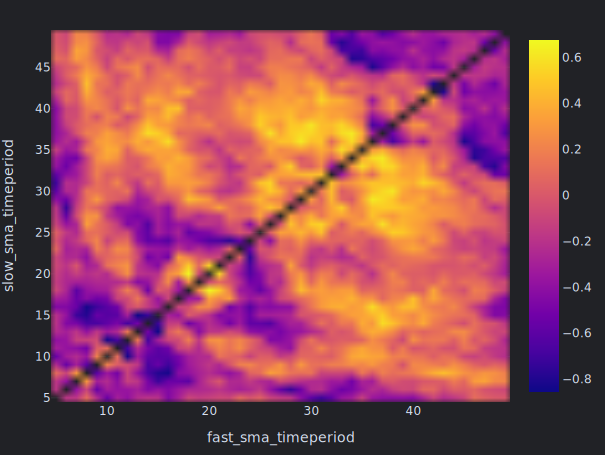

In [126]:
strat_returns_acc_slices["D"].sharpe_ratio().vbt.heatmap(
    x_level="fast_sma_timeperiod", 
    y_level="slow_sma_timeperiod",
    symmetric=True
).show_svg()

/home/jupyter/miniconda3/envs/vectorbtpro/lib/python3.10/site-packages/jupyter_client/session.py:721: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant



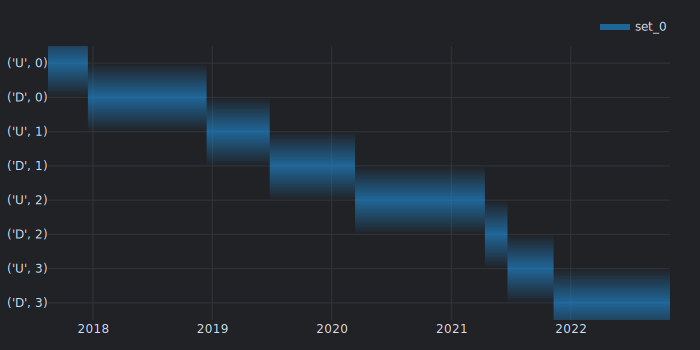

In [127]:
trend_splitter = trend_splitter.break_up_splits("by_gap", sort=True)
trend_splitter.plot().show_svg()

In [128]:
strat_pf_slices = strat_pf.split(trend_splitter)
strat_pf_slices

trend  split_part
U      0             Portfolio(\n    wrapper=ArrayWrapper(\n       ...
D      0             Portfolio(\n    wrapper=ArrayWrapper(\n       ...
U      1             Portfolio(\n    wrapper=ArrayWrapper(\n       ...
D      1             Portfolio(\n    wrapper=ArrayWrapper(\n       ...
U      2             Portfolio(\n    wrapper=ArrayWrapper(\n       ...
D      2             Portfolio(\n    wrapper=ArrayWrapper(\n       ...
U      3             Portfolio(\n    wrapper=ArrayWrapper(\n       ...
D      3             Portfolio(\n    wrapper=ArrayWrapper(\n       ...
dtype: object

In [129]:
trend_range_perf = strat_pf_slices.apply(lambda pf: pf.sharpe_ratio)
median_trend_perf = trend_range_perf.median(axis=1)
median_trend_perf

trend  split_part
U      0             5.057454
D      0            -0.177558
U      1             2.874709
D      1             0.127975
U      2             2.057640
D      2             0.698794
U      3            -0.332780
D      3             0.128991
dtype: float64

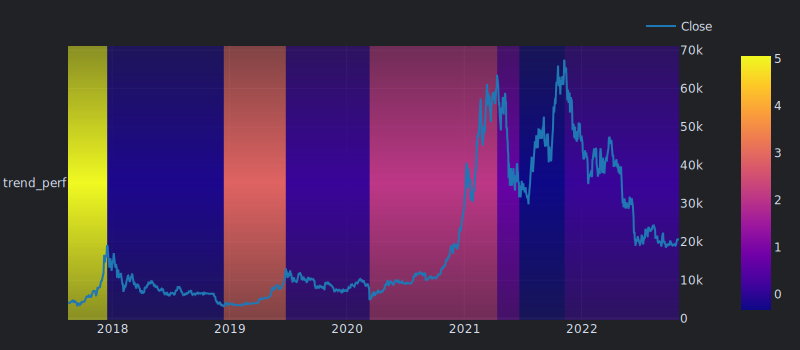

In [130]:
trend_perf_ts = data.symbol_wrapper.fill().rename("trend_perf")
for label, sr in trend_splitter.bounds.iterrows():
    trend_perf_ts.iloc[sr["start"]:sr["end"]] = median_trend_perf[label]
data.close.vbt.overlay_with_heatmap(trend_perf_ts).show_svg()

#### Column stacking

In [131]:
close_stacked = pd.concat(
    close_slices.values.tolist(), 
    axis=1, 
    keys=close_slices.index
)
print(close_stacked)

split_year                     2018       2019       2020       2021          
set                           train test train test train test train      test
Open time                                                                     
2018-01-01 00:00:00+00:00  13380.00  NaN   NaN  NaN   NaN  NaN   NaN       NaN
2018-01-02 00:00:00+00:00  14675.11  NaN   NaN  NaN   NaN  NaN   NaN       NaN
2018-01-03 00:00:00+00:00  14919.51  NaN   NaN  NaN   NaN  NaN   NaN       NaN
2018-01-04 00:00:00+00:00  15059.54  NaN   NaN  NaN   NaN  NaN   NaN       NaN
2018-01-05 00:00:00+00:00  16960.39  NaN   NaN  NaN   NaN  NaN   NaN       NaN
...                             ...  ...   ...  ...   ...  ...   ...       ...
2021-12-27 00:00:00+00:00       NaN  NaN   NaN  NaN   NaN  NaN   NaN  50701.44
2021-12-28 00:00:00+00:00       NaN  NaN   NaN  NaN   NaN  NaN   NaN  47543.74
2021-12-29 00:00:00+00:00       NaN  NaN   NaN  NaN   NaN  NaN   NaN  46464.66
2021-12-30 00:00:00+00:00       NaN  NaN   NaN  NaN 

In [132]:
get_total_return(close_stacked)

split_year  set  
2018        train   -0.522416
            test    -0.417491
2019        train    1.858493
            test    -0.322797
2020        train    0.269093
            test     2.132976
2021        train    0.194783
            test     0.379417
Name: total_return, dtype: float64

In [133]:
close_stacked = splitter.take(data.close, into="stacked")
close_stacked.shape

(1461, 8)

In [134]:
close_stacked = splitter.take(data.close, into="reset_stacked")
print(close_stacked)

split_year      2018               2019               2020            \
set            train     test     train      test    train      test   
0           13380.00  6356.81   3797.14  10624.93  7200.85   9232.00   
1           14675.11  6615.29   3858.56  10842.85  6965.71   9086.54   
2           14919.51  6513.86   3766.78  11940.00  7344.96   9058.26   
3           15059.54  6586.98   3792.01  11145.67  7354.11   9135.46   
4           16960.39  6529.20   3770.96  10970.73  7358.75   9069.41   
..               ...      ...       ...       ...      ...       ...   
179          6197.92  3567.91  11903.13   7254.74  9116.35  26281.66   
180          6390.07  3839.26  10854.10   7316.14  9192.56  27079.41   
181              NaN  3695.32       NaN   7388.24  9138.55  27385.00   
182              NaN  3801.91       NaN   7246.00      NaN  28875.54   
183              NaN  3702.90       NaN   7195.23      NaN  28923.63   

split_year      2021            
set            train      test

In [135]:
close_stacked = splitter.take(data.close, into="from_end_stacked")
print(close_stacked)

split_year      2018               2019               2020            \
set            train     test     train      test    train      test   
0                NaN  6356.81       NaN  10624.93      NaN   9232.00   
1                NaN  6615.29       NaN  10842.85      NaN   9086.54   
2                NaN  6513.86       NaN  11940.00  7200.85   9058.26   
3           13380.00  6586.98   3797.14  11145.67  6965.71   9135.46   
4           14675.11  6529.20   3858.56  10970.73  7344.96   9069.41   
..               ...      ...       ...       ...      ...       ...   
179          6070.78  3567.91  13093.80   7254.74  9162.21  26281.66   
180          6133.73  3839.26  11329.99   7316.14  9012.00  27079.41   
181          5853.98  3695.32  12400.63   7388.24  9116.35  27385.00   
182          6197.92  3801.91  11903.13   7246.00  9192.56  28875.54   
183          6390.07  3702.90  10854.10   7195.23  9138.55  28923.63   

split_year      2021            
set            train      test

In [136]:
close_stacked = splitter.take(data.close, into="reset_stacked_by_set")
close_stacked

set
train    split_year      2018      2019     2020      2...
test     split_year     2018      2019      2020      2...
dtype: object

In [137]:
print(close_stacked["train"])

split_year      2018      2019     2020      2021
0           13380.00   3797.14  7200.85  29331.69
1           14675.11   3858.56  6965.71  32178.33
2           14919.51   3766.78  7344.96  33000.05
3           15059.54   3792.01  7354.11  31988.71
4           16960.39   3770.96  7358.75  33949.53
..               ...       ...      ...       ...
177          6133.73  11329.99  9162.21  34700.34
178          5853.98  12400.63  9012.00  34494.89
179          6197.92  11903.13  9116.35  35911.73
180          6390.07  10854.10  9192.56  35045.00
181              NaN       NaN  9138.55       NaN

[182 rows x 4 columns]


In [138]:
print(182 * 8)
print(1461 * 8)
print(1 - 1456 / 11688)

1456
11688
0.8754277891854894


In [139]:
index_slices = splitter.take(data.index)
index_slices

split_year  set  
2018        train    DatetimeIndex(['2018-01-01 00:00:00+00:00', '2...
            test     DatetimeIndex(['2018-07-01 00:00:00+00:00', '2...
2019        train    DatetimeIndex(['2019-01-01 00:00:00+00:00', '2...
            test     DatetimeIndex(['2019-07-01 00:00:00+00:00', '2...
2020        train    DatetimeIndex(['2020-01-01 00:00:00+00:00', '2...
            test     DatetimeIndex(['2020-07-01 00:00:00+00:00', '2...
2021        train    DatetimeIndex(['2021-01-01 00:00:00+00:00', '2...
            test     DatetimeIndex(['2021-07-01 00:00:00+00:00', '2...
dtype: object

In [140]:
close_stacked_wb = splitter.take(
    data.close, 
    into="reset_stacked_by_set",
    attach_bounds="index",
    right_inclusive=True
)
print(close_stacked_wb["train"])

split_year                      2018                      2019  \
start      2018-01-01 00:00:00+00:00 2019-01-01 00:00:00+00:00   
end        2018-06-30 00:00:00+00:00 2019-06-30 00:00:00+00:00   
0                           13380.00                   3797.14   
1                           14675.11                   3858.56   
2                           14919.51                   3766.78   
3                           15059.54                   3792.01   
4                           16960.39                   3770.96   
..                               ...                       ...   
177                          6133.73                  11329.99   
178                          5853.98                  12400.63   
179                          6197.92                  11903.13   
180                          6390.07                  10854.10   
181                              NaN                       NaN   

split_year                      2020                      2021  
start     

In [141]:
@vbt.parameterized(merge_func="concat")
def set_sma_crossover_perf(close, fast_window, slow_window, freq):
    fast_sma = vbt.talib("sma").run(
        close, fast_window, short_name="fast_sma", hide_params=True) 
    slow_sma = vbt.talib("sma").run(
        close, slow_window, short_name="slow_sma", hide_params=True) 
    entries = fast_sma.real_crossed_above(slow_sma)
    exits = fast_sma.real_crossed_below(slow_sma)
    pf = vbt.Portfolio.from_signals(
        close, entries, exits, freq=freq, direction="both")
    return pf.sharpe_ratio

In [142]:
train_perf = set_sma_crossover_perf(
    close_stacked["train"],
    vbt.Param(np.arange(5, 50), condition="x < slow_window"),
    vbt.Param(np.arange(5, 50)),
    data.index.freq,
    _execute_kwargs=dict(
        clear_cache=50,
        collect_garbage=50
    )
)

  0%|          | 1/990 [00:06<1:54:17,  6.93s/it, fast_window=5, slow_window=7]

In [143]:
train_perf

fast_window  slow_window  split_year
5            6            2018          1.158471
                          2019          1.901410
                          2020         -0.426441
                          2021          0.052654
             7            2018          2.231909
                                          ...   
47           49           2021         -0.446099
48           49           2018         -1.169584
                          2019          3.727154
                          2020         -1.913321
                          2021         -0.400270
Name: sharpe_ratio, Length: 3960, dtype: float64

/home/jupyter/miniconda3/envs/vectorbtpro/lib/python3.10/site-packages/jupyter_client/session.py:721: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant

/home/jupyter/miniconda3/envs/vectorbtpro/lib/python3.10/site-packages/jupyter_client/session.py:721: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant

/home/jupyter/miniconda3/envs/vectorbtpro/lib/python3.10/site-packages/jupyter_client/session.py:721: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant

/home/jupyter/miniconda3/envs/vectorbtpro/lib/python3.10/site-packages/jupyt

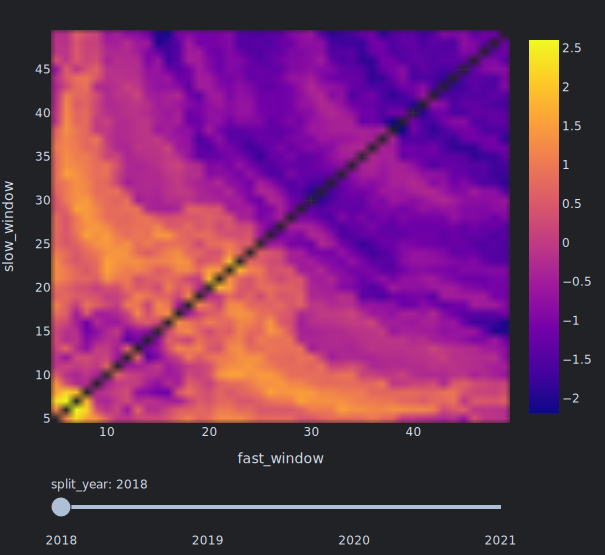

In [144]:
train_perf.vbt.heatmap(
    x_level="fast_window",
    y_level="slow_window",
    slider_level="split_year",
    symmetric=True
).show_svg()  # replace with show()

In [145]:
@njit
def prox_median_nb(arr):
    if (~np.isnan(arr)).sum() < 20:
        return np.nan
    return np.nanmedian(arr)

prox_perf_list = []
for split_label, perf_sr in train_perf.groupby("split_year"):
    perf_df = perf_sr.vbt.unstack_to_df(0, [1, 2])
    prox_perf_df = perf_df.vbt.proximity_apply(2, prox_median_nb)
    prox_perf_sr = prox_perf_df.stack([0, 1])
    prox_perf_list.append(prox_perf_sr.reindex(perf_sr.index))

train_prox_perf = pd.concat(prox_perf_list)
train_prox_perf

/tmp/ipykernel_433292/876608526.py:11: FutureWarning:

The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.

/tmp/ipykernel_433292/876608526.py:11: FutureWarning:

The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.

/tmp/ipykernel_433292/876608526.py:11: FutureWarning:

The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.

/tmp/ipykernel_433292/876608526.py:11: FutureWarning:

The previous implementation of stack is deprecated and

fast_window  slow_window  split_year
5            6            2018         NaN
             7            2018         NaN
             8            2018         NaN
             9            2018         NaN
             10           2018         NaN
                                        ..
46           48           2021         NaN
             49           2021         NaN
47           48           2021         NaN
             49           2021         NaN
48           49           2021         NaN
Length: 3960, dtype: float64

/home/jupyter/miniconda3/envs/vectorbtpro/lib/python3.10/site-packages/jupyter_client/session.py:721: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant

/home/jupyter/miniconda3/envs/vectorbtpro/lib/python3.10/site-packages/jupyter_client/session.py:721: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant

/home/jupyter/miniconda3/envs/vectorbtpro/lib/python3.10/site-packages/jupyter_client/session.py:721: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant

/home/jupyter/miniconda3/envs/vectorbtpro/lib/python3.10/site-packages/jupyt

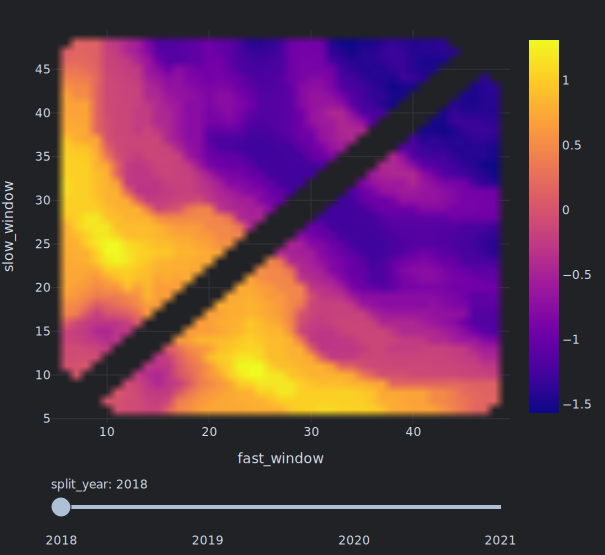

In [146]:
train_prox_perf.vbt.heatmap(
    x_level="fast_window",
    y_level="slow_window",
    slider_level="split_year",
    symmetric=True
).show_svg()  # replace with show()

In [147]:
best_params = train_prox_perf.groupby("split_year").idxmax()
best_params = train_prox_perf[best_params].index
train_prox_perf[best_params]

fast_window  slow_window  split_year
10           24           2018          1.311910
9            39           2019          3.801643
14           19           2020          2.077684
31           41           2021          2.142695
dtype: float64

In [148]:
test_perf = set_sma_crossover_perf(
    vbt.RepEval(
        "test_close.iloc[:, [config_idx]]", 
        context=dict(test_close=close_stacked["test"])
    ),
    vbt.Param(best_params.get_level_values("fast_window"), level=0),
    vbt.Param(best_params.get_level_values("slow_window"), level=0),
    data.index.freq
)
test_perf

fast_window  slow_window  split_year
10           24           2018         -0.616204
9            39           2019          0.017269
14           19           2020          4.768589
31           41           2021         -0.363900
Name: sharpe_ratio, dtype: float64

In [149]:
def get_index_sharpe(index):
    return data.loc[index].run("from_holding").sharpe_ratio

index_slices.xs("test", level="set").apply(get_index_sharpe)

split_year
2018   -1.327655
2019   -0.788038
2020    4.425057
2021    1.304871
dtype: float64

#### Row stacking

In [150]:
block_size = int(3.15 * len(data.index) ** (1 / 3))
block_splitter = vbt.Splitter.from_rolling(
    data.index, 
    length=block_size, 
    offset=1,
    offset_anchor="prev_start"
)
block_splitter.n_splits

1864

/home/jupyter/miniconda3/envs/vectorbtpro/lib/python3.10/site-packages/jupyter_client/session.py:721: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant



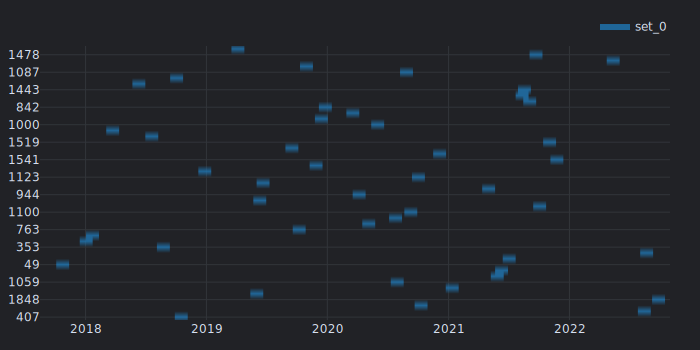

In [151]:
size = int(block_splitter.n_splits / block_size)
sample_splitter = block_splitter.shuffle_splits(size=size, replace=True)
sample_splitter.plot().show_svg()

In [152]:
returns = data.returns
sample_rets = sample_splitter.take(returns, into="stacked", stack_axis=0)
sample_rets

split  Open time                
578    2019-03-18 00:00:00+00:00    0.001675
       2019-03-19 00:00:00+00:00    0.006951
       2019-03-20 00:00:00+00:00    0.006851
       2019-03-21 00:00:00+00:00   -0.015434
       2019-03-22 00:00:00+00:00    0.001580
                                      ...   
407    2018-11-01 00:00:00+00:00    0.005975
       2018-11-02 00:00:00+00:00    0.003741
       2018-11-03 00:00:00+00:00   -0.007288
       2018-11-04 00:00:00+00:00    0.015462
       2018-11-05 00:00:00+00:00   -0.002600
Name: BTCUSDT, Length: 1833, dtype: float64

/tmp/ipykernel_433292/739870584.py:2: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



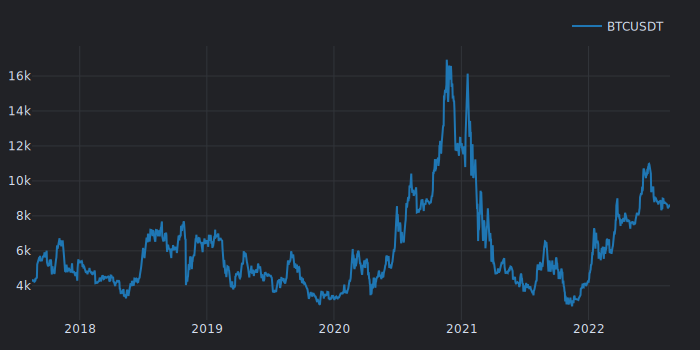

In [153]:
sample_rets.index = data.index[:len(sample_rets)]
sample_cumrets = data.close[0] * (sample_rets + 1).cumprod()
sample_cumrets.vbt.plot().show_svg()

In [154]:
samples_rets_list = []
for i in vbt.ProgressBar(range(1000)):
    sample_spl = block_splitter.shuffle_splits(size=size, replace=True)
    sample_rets = sample_spl.take(returns, into="stacked", stack_axis=0)
    sample_rets.index = returns.index[:len(sample_rets)]
    sample_rets.name = i
    samples_rets_list.append(sample_rets)
sample_rets_stacked = pd.concat(samples_rets_list, axis=1)

 20%|##        | 202/1000 [00:02<00:07, 100.96it/s]

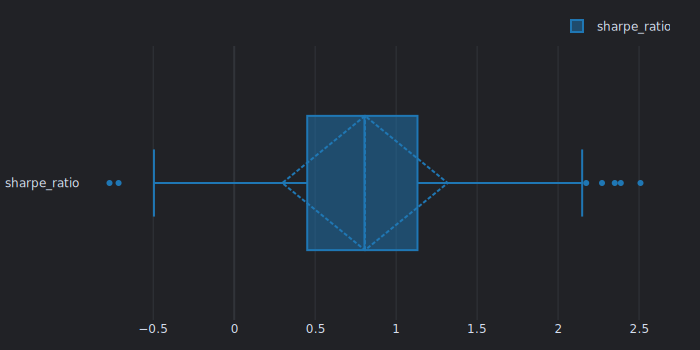

In [155]:
sample_sharpe = sample_rets_stacked.vbt.returns.sharpe_ratio()
sample_sharpe.vbt.boxplot(horizontal=True).show_svg()

In [156]:
sample_sharpe.quantile(0.025), sample_sharpe.quantile(0.975)

(-0.11143080725401439, 1.819046061550524)

### Applying

In [157]:
splitter.apply(
    get_total_return,
    vbt.Takeable(data.close),
    merge_func="concat"
)

split_year  set  
2018        train   -0.522416
            test    -0.417491
2019        train    1.858493
            test    -0.322797
2020        train    0.269093
            test     2.132976
2021        train    0.194783
            test     0.379417
dtype: float64

In [158]:
splitter.apply(
    get_total_return,
    vbt.RepFunc(lambda range_: data.close[range_]),
    merge_func="concat"
)

split_year  set  
2018        train   -0.522416
            test    -0.417491
2019        train    1.858493
            test    -0.322797
2020        train    0.269093
            test     2.132976
2021        train    0.194783
            test     0.379417
dtype: float64

In [159]:
def get_total_return(range_, data):
    return data.returns[range_].vbt.returns.total()

splitter.apply(
    get_total_return,
    vbt.Rep("range_"),
    data,
    merge_func="concat"
)

split_year  set  
2018        train   -0.534128
            test    -0.420523
2019        train    1.931243
            test    -0.337096
2020        train    0.270084
            test     2.165013
2021        train    0.211639
            test     0.318788
dtype: float64

In [160]:
def get_total_return(data):
    return data.returns.vbt.returns.total()

splitter.apply(
    get_total_return,
    vbt.Takeable(data),
    merge_func="concat"
)

split_year  set  
2018        train   -0.522416
            test    -0.417491
2019        train    1.858493
            test    -0.322797
2020        train    0.269093
            test     2.132976
2021        train    0.194783
            test     0.379417
dtype: float64

In [161]:
splitter.apply(
    get_total_return,
    vbt.Takeable(data),
    set_group_by=True,
    merge_func="concat"
)

split_year
2018   -0.723251
2019    0.894908
2020    3.016697
2021    0.575665
dtype: float64

In [162]:
splitter.apply(
    get_total_return,
    vbt.Takeable(data),
    split=[2020, 2021],
    set_="train",
    merge_func="concat"
)

split_year
2020    0.269093
2021    0.194783
dtype: float64

In [163]:
train_perf = splitter.apply(
    sma_crossover_perf,
    vbt.Takeable(data),
    vbt.Param(np.arange(5, 50), condition="x < slow_window"),
    vbt.Param(np.arange(5, 50)),
    _execute_kwargs=dict(
        clear_cache=50,
        collect_garbage=50
    ),
    set_="train",
    merge_func="concat",
)

  0%|          | 0/4 [00:09<?, ?it/s, split_year=2018]

  5%|5         | 50/990 [00:09<03:05,  5.08it/s, fast_window=6, slow_window=13]

In [164]:
train_perf

split_year  fast_window  slow_window
2018        5            6              1.161661
                         7              2.238117
                         8              1.583246
                         9              1.369400
                         10             0.563251
                                          ...   
2021        46           48            -0.238667
                         49            -0.437822
            47           48            -0.799317
                         49            -0.447324
            48           49            -0.401369
Length: 3960, dtype: float64

In [165]:
best_params = train_perf.groupby("split_year").idxmax()
best_params = train_perf[best_params].index
train_perf[best_params]

split_year  fast_window  slow_window
2018        6            7              2.612006
2019        35           36             4.246530
2020        16           17             2.605763
2021        32           45             3.073246
dtype: float64

In [166]:
best_fast_windows = best_params.get_level_values("fast_window")
best_slow_windows = best_params.get_level_values("slow_window")

test_perf = splitter.apply(
    sma_crossover_perf,
    vbt.Takeable(data),
    vbt.RepFunc(lambda split_idx: best_fast_windows[split_idx]),
    vbt.RepFunc(lambda split_idx: best_slow_windows[split_idx]),
    set_="test",
    merge_func="concat"
)
test_perf

split_year
2018    1.501380
2019    0.152723
2020    4.473387
2021   -1.147178
dtype: float64

#### Iteration schemes

In [167]:
def cv_sma_crossover(
    data, 
    fast_windows, 
    slow_windows, 
    split_idx,
    set_idx,
    train_perf_list
):
    if set_idx == 0:
        train_perf = sma_crossover_perf(
            data,
            vbt.Param(fast_windows, condition="x < slow_window"),
            vbt.Param(slow_windows),
            _execute_kwargs=dict(
                clear_cache=50,
                collect_garbage=50
            )
        )
        train_perf_list.append(train_perf)
        best_params = train_perf.idxmax()
        return train_perf[[best_params]]
    else:
        train_perf = train_perf_list[split_idx]
        best_params = train_perf.idxmax()
        test_perf = sma_crossover_perf(
            data,
            vbt.Param([best_params[0]]),
            vbt.Param([best_params[1]]),
        )
        return test_perf
    
train_perf_list = []
cv_perf = splitter.apply(
    cv_sma_crossover,
    vbt.Takeable(data),
    np.arange(5, 50),
    np.arange(5, 50),
    vbt.Rep("split_idx"),
    vbt.Rep("set_idx"),
    train_perf_list,
    iteration="set_major",
    merge_func="concat",
)

  0%|          | 0/8 [00:12<?, ?it/s, set=train, split_year=2018]

  5%|5         | 50/990 [00:12<03:51,  4.06it/s, fast_window=6, slow_window=13]

In [168]:
train_perf = pd.concat(train_perf_list, keys=splitter.split_labels)
train_perf

split_year  fast_window  slow_window
2018        5            6              1.161661
                         7              2.238117
                         8              1.583246
                         9              1.369400
                         10             0.563251
                                          ...   
2021        46           48            -0.238667
                         49            -0.437822
            47           48            -0.799317
                         49            -0.447324
            48           49            -0.401369
Length: 3960, dtype: float64

In [169]:
cv_perf

set    split_year  fast_window  slow_window
train  2018        6            7              2.612006
       2019        35           36             4.246530
       2020        16           17             2.605763
       2021        32           45             3.073246
test   2018        6            7              1.501380
       2019        35           36             0.152723
       2020        16           17             4.473387
       2021        32           45            -1.147178
dtype: float64

#### Merging

In [170]:
def get_entries_and_exits(data, fast_window, slow_window):
    fast_sma = data.run("sma", fast_window, short_name="fast_sma")
    slow_sma = data.run("sma", slow_window, short_name="slow_sma")
    entries = fast_sma.real_crossed_above(slow_sma)
    exits = fast_sma.real_crossed_below(slow_sma)
    return entries, exits

entries, exits = splitter.apply(
    get_entries_and_exits,
    vbt.Takeable(data),
    20,
    30,
    merge_func="column_stack"
)

print(entries)

split_year                  2018       2019       2020       2021       
set                        train test train test train test train   test
Open time                                                               
2018-01-01 00:00:00+00:00  False  NaN   NaN  NaN   NaN  NaN   NaN    NaN
2018-01-02 00:00:00+00:00  False  NaN   NaN  NaN   NaN  NaN   NaN    NaN
2018-01-03 00:00:00+00:00  False  NaN   NaN  NaN   NaN  NaN   NaN    NaN
2018-01-04 00:00:00+00:00  False  NaN   NaN  NaN   NaN  NaN   NaN    NaN
2018-01-05 00:00:00+00:00  False  NaN   NaN  NaN   NaN  NaN   NaN    NaN
...                          ...  ...   ...  ...   ...  ...   ...    ...
2021-12-27 00:00:00+00:00    NaN  NaN   NaN  NaN   NaN  NaN   NaN  False
2021-12-28 00:00:00+00:00    NaN  NaN   NaN  NaN   NaN  NaN   NaN  False
2021-12-29 00:00:00+00:00    NaN  NaN   NaN  NaN   NaN  NaN   NaN  False
2021-12-30 00:00:00+00:00    NaN  NaN   NaN  NaN   NaN  NaN   NaN  False
2021-12-31 00:00:00+00:00    NaN  NaN   NaN  NaN   

In [171]:
entries, exits = splitter.apply(
    get_entries_and_exits,
    vbt.Takeable(data),
    20,
    30,
    merge_all=False,
    merge_func="row_stack"
)

entries.loc[2018]

set    Open time                
train  2018-01-01 00:00:00+00:00    False
       2018-01-02 00:00:00+00:00    False
       2018-01-03 00:00:00+00:00    False
       2018-01-04 00:00:00+00:00    False
       2018-01-05 00:00:00+00:00    False
                                    ...  
test   2018-12-27 00:00:00+00:00    False
       2018-12-28 00:00:00+00:00    False
       2018-12-29 00:00:00+00:00    False
       2018-12-30 00:00:00+00:00    False
       2018-12-31 00:00:00+00:00     True
Length: 365, dtype: bool

In [172]:
def get_signal_count(*args, **kwargs):
    entries, exits = get_entries_and_exits(*args, **kwargs)
    return entries.vbt.signals.total(), exits.vbt.signals.total()

entry_count, exit_count = splitter.apply(
    get_signal_count,
    vbt.Takeable(data),
    20,
    30,
    merge_func="concat",
    attach_bounds="index"
)
entry_count

split_year  set    start                      end                      
2018        train  2018-01-01 00:00:00+00:00  2018-07-01 00:00:00+00:00    2
            test   2018-07-01 00:00:00+00:00  2019-01-01 00:00:00+00:00    4
2019        train  2019-01-01 00:00:00+00:00  2019-07-01 00:00:00+00:00    2
            test   2019-07-01 00:00:00+00:00  2020-01-01 00:00:00+00:00    3
2020        train  2020-01-01 00:00:00+00:00  2020-07-01 00:00:00+00:00    1
            test   2020-07-01 00:00:00+00:00  2021-01-01 00:00:00+00:00    2
2021        train  2021-01-01 00:00:00+00:00  2021-07-01 00:00:00+00:00    4
            test   2021-07-01 00:00:00+00:00  2022-01-01 00:00:00+00:00    1
dtype: int64

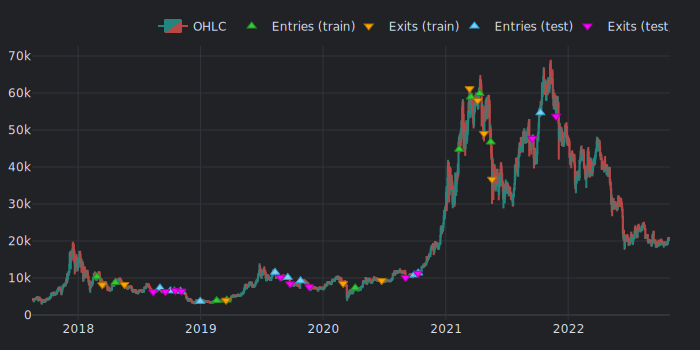

In [173]:
def plot_entries_and_exits(results, data, keys):
    set_labels = keys.get_level_values("set")
    fig = data.plot(plot_volume=False)
    train_seen = False
    test_seen = False

    for i in range(len(results)):
        entries, exits = results[i]
        set_label = set_labels[i]
        if set_label == "train":
            entries.vbt.signals.plot_as_entries(
                data.close,
                trace_kwargs=dict(
                    marker=dict(color="limegreen"), 
                    name=f"Entries ({set_label})",
                    legendgroup=f"Entries ({set_label})",
                    showlegend=not train_seen
                ),
                fig=fig
            ),
            exits.vbt.signals.plot_as_exits(
                data.close,
                trace_kwargs=dict(
                    marker=dict(color="orange"), 
                    name=f"Exits ({set_label})",
                    legendgroup=f"Exits ({set_label})",
                    showlegend=not train_seen
                ),
                fig=fig
            )
            train_seen = True
        else:
            entries.vbt.signals.plot_as_entries(
                data.close,
                trace_kwargs=dict(
                    marker=dict(color="skyblue"), 
                    name=f"Entries ({set_label})",
                    legendgroup=f"Entries ({set_label})",
                    showlegend=not test_seen
                ),
                fig=fig
            ),
            exits.vbt.signals.plot_as_exits(
                data.close,
                trace_kwargs=dict(
                    marker=dict(color="magenta"), 
                    name=f"Exits ({set_label})",
                    legendgroup=f"Entries ({set_label})",
                    showlegend=not test_seen
                ),
                fig=fig
            )
            test_seen = True
    return fig

splitter.apply(
    get_entries_and_exits,
    vbt.Takeable(data),
    20,
    30,
    merge_func=plot_entries_and_exits,
    merge_kwargs=dict(data=data, keys=vbt.Rep("keys")),
).show_svg()

#### Decorators

In [174]:
@vbt.split(splitter=splitter)
def get_split_total_return(data):
    return data.returns.vbt.returns.total()

get_split_total_return(vbt.Takeable(data))

split_year  set  
2018        train   -0.522416
            test    -0.417491
2019        train    1.858493
            test    -0.322797
2020        train    0.269093
            test     2.132976
2021        train    0.194783
            test     0.379417
dtype: float64

In [175]:
def get_total_return(data):
    return data.returns.vbt.returns.total()

get_split_total_return = vbt.split(
    get_total_return, 
    splitter=splitter
)
get_split_total_return(vbt.Takeable(data))

split_year  set  
2018        train   -0.522416
            test    -0.417491
2019        train    1.858493
            test    -0.322797
2020        train    0.269093
            test     2.132976
2021        train    0.194783
            test     0.379417
dtype: float64

In [176]:
@vbt.split
def get_split_total_return(data):
    return data.returns.vbt.returns.total()

get_split_total_return(vbt.Takeable(data), _splitter=splitter)

split_year  set  
2018        train   -0.522416
            test    -0.417491
2019        train    1.858493
            test    -0.322797
2020        train    0.269093
            test     2.132976
2021        train    0.194783
            test     0.379417
dtype: float64

In [177]:
get_split_total_return(
    vbt.Takeable(data.loc["2020":"2020"]), 
    _splitter="from_rolling", 
    _splitter_kwargs=dict(length="30d")
)

split
0     0.321123
1    -0.088666
2    -0.250531
3     0.369418
4     0.093628
5    -0.059949
6     0.186424
7     0.020706
8    -0.069256
9     0.211424
10    0.372754
11    0.441005
dtype: float64

In [178]:
get_total_return_by_month = vbt.split(
    get_total_return,
    splitter="from_grouper", 
    splitter_kwargs=dict(by=vbt.RepEval("index.to_period('M')")),
    takeable_args=["data"]
)

get_total_return_by_month(data.loc["2020":"2020"])

file:1: UserWarning:

Converting to PeriodArray/Index representation will drop timezone information.



Open time
2020-01    0.298859
2020-02   -0.091746
2020-03   -0.248649
2020-04    0.297622
2020-05    0.070388
2020-06   -0.104131
2020-07    0.227844
2020-08   -0.012851
2020-09   -0.096073
2020-10    0.298694
2020-11    0.431230
2020-12    0.541364
Freq: M, dtype: float64

In [179]:
cv_sma_crossover_perf = vbt.split(
    sma_crossover_perf, 
    splitter="from_single",
    splitter_kwargs=dict(split=0.6, set_labels=["train", "test"]),
    takeable_args=["data"],
    merge_func="concat",
)

In [180]:
train_perf = cv_sma_crossover_perf(
    data.loc["2020":"2021"],
    vbt.Param(np.arange(5, 50), condition="x < slow_window"),
    vbt.Param(np.arange(5, 50)),
    p_execute_kwargs=dict(
        clear_cache=50,
        collect_garbage=50
    ),
    _forward_kwargs_as={
        "p_execute_kwargs": "_execute_kwargs"
    },
    _apply_kwargs=dict(set_="train")
)

  3%|3         | 32/990 [00:02<01:02, 15.42it/s, fast_window=5, slow_window=38]

In [181]:
train_perf

fast_window  slow_window
5            6              1.160003
             7              1.122994
             8              2.054193
             9              1.880043
             10             1.632951
                              ...   
46           48             1.362618
             49             1.415010
47           48             1.317795
             49             1.250835
48           49             0.160916
Length: 990, dtype: float64

In [182]:
test_perf = cv_sma_crossover_perf(
    data.loc["2020":"2021"],
    train_perf.idxmax()[0],
    train_perf.idxmax()[1],
    _apply_kwargs=dict(set_="test")
)

In [183]:
test_perf

1.2596407796960982

In [184]:
@njit(nogil=True)
def sma_crossover_perf_nb(close, fast_window, slow_window, ann_factor):
    fast_sma = vbt.nb.ma_nb(close, fast_window)
    slow_sma = vbt.nb.ma_nb(close, slow_window)
    entries = vbt.nb.crossed_above_nb(fast_sma, slow_sma)
    exits = vbt.nb.crossed_above_nb(slow_sma, fast_sma)
    sim_out = vbt.pf_nb.from_signals_nb(
        target_shape=close.shape,
        group_lens=np.full(close.shape[1], 1),
        close=close,
        long_entries=entries,
        short_entries=exits,
        save_returns=True
    )
    return vbt.ret_nb.sharpe_ratio_nb(
        sim_out.in_outputs.returns, 
        ann_factor
    )

In [185]:
sma_crossover_perf_nb(vbt.to_2d_array(data.close), 20, 30, 365)

array([1.04969317])

In [186]:
cv_sma_crossover_perf = vbt.cv_split(
    sma_crossover_perf_nb,
    splitter="from_rolling",
    splitter_kwargs=dict(
        length=360, 
        split=0.5, 
        set_labels=["train", "test"]
    ),
    takeable_args=["close"],
    merge_func="concat",
    parameterized_kwargs=dict(
        engine="dask", 
        chunk_len="auto",
    )
)

grid_perf, best_perf = cv_sma_crossover_perf(
    vbt.to_2d_array(data.close),
    vbt.Param(np.arange(5, 50), condition="x < slow_window"),
    vbt.Param(np.arange(5, 50)),
    pd.Timedelta(days=365) // data.index.freq,
    _merge_kwargs=dict(wrapper=data.symbol_wrapper),
    _index=data.index,
    _return_grid="all"
)

 11%|#1        | 1/9 [00:02<00:17,  2.22s/it, split=1]

In [187]:
grid_perf

split  set    fast_window  slow_window  symbol 
0      train  5            6            BTCUSDT    1.771782
                           7            BTCUSDT    2.206458
                           8            BTCUSDT    2.705892
                           9            BTCUSDT    1.430768
                           10           BTCUSDT    0.851692
                                                     ...   
8      test   46           48           BTCUSDT    0.637332
                           49           BTCUSDT   -0.424650
              47           48           BTCUSDT   -0.214946
                           49           BTCUSDT    0.231712
              48           49           BTCUSDT   -0.351245
Length: 17820, dtype: float64

In [188]:
best_perf

split  set    fast_window  slow_window  symbol 
0      train  19           34           BTCUSDT    4.392966
       test   19           34           BTCUSDT    0.535497
1      train  6            7            BTCUSDT    2.545991
       test   6            7            BTCUSDT   -1.101692
2      train  18           20           BTCUSDT    4.363491
       test   18           20           BTCUSDT    1.692070
3      train  14           18           BTCUSDT    3.615833
       test   14           18           BTCUSDT    0.035444
4      train  18           21           BTCUSDT    3.236440
       test   18           21           BTCUSDT    1.882290
5      train  20           27           BTCUSDT    3.371474
       test   20           27           BTCUSDT    2.574914
6      train  11           18           BTCUSDT    4.657549
       test   11           18           BTCUSDT   -2.067505
7      train  29           30           BTCUSDT    3.388797
       test   29           30           BTCUSDT    0

In [189]:
best_train_perf = best_perf.xs("train", level="set")
best_test_perf = best_perf.xs("test", level="set")
best_train_perf.corr(best_test_perf)

-0.2164151708389123

/home/jupyter/miniconda3/envs/vectorbtpro/lib/python3.10/site-packages/jupyter_client/session.py:721: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant



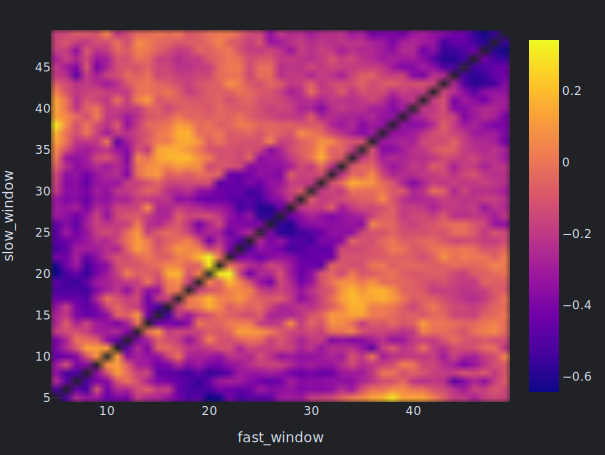

In [190]:
param_cross_set_corr = grid_perf\
    .unstack("set")\
    .groupby(["fast_window", "slow_window"])\
    .apply(lambda x: x["train"].corr(x["test"]))
param_cross_set_corr.vbt.heatmap(symmetric=True).show_svg()

In [191]:
grid_test_perf = grid_perf.xs("test", level="set")
grid_df = grid_test_perf.rename("grid").reset_index()
del grid_df["fast_window"]
del grid_df["slow_window"]
best_df = best_test_perf.rename("best").reset_index()
del best_df["fast_window"]
del best_df["slow_window"]
merged_df = pd.merge(grid_df, best_df, on=["split", "symbol"])
grid_better_mask = merged_df["grid"] > merged_df["best"]
grid_better_mask.index = grid_test_perf.index
grid_better_cnt = grid_better_mask.groupby(["split", "symbol"]).mean()
grid_better_cnt

split  symbol 
0      BTCUSDT    0.242424
1      BTCUSDT    0.988889
2      BTCUSDT    0.214141
3      BTCUSDT    0.404040
4      BTCUSDT    0.359596
5      BTCUSDT    0.963636
6      BTCUSDT    0.908081
7      BTCUSDT    0.342424
8      BTCUSDT    0.250505
dtype: float64

In [192]:
cv_splitter = cv_sma_crossover_perf(
    _index=data.index, 
    _return_splitter=True
)
stacked_close = cv_splitter.take(
    data.close, 
    into="reset_stacked",
    set_="test"
)
hold_pf = vbt.Portfolio.from_holding(stacked_close, freq="daily")
hold_perf = hold_pf.sharpe_ratio
hold_perf

split
0   -0.430642
1   -1.741407
2    3.408079
3   -0.556471
4    0.954291
5    3.241618
6    0.686198
7   -0.038013
8   -0.917722
Name: sharpe_ratio, dtype: float64

### Modeling

In [193]:
X = data.run("talib")
X.shape

/home/jupyter/miniconda3/envs/vectorbtpro/lib/python3.10/site-packages/vectorbtpro/utils/execution.py:157: UserWarning:

mavp: run() missing 1 required positional argument: 'periods'



(1902, 174)

In [194]:
trendlb = data.run("trendlb", 1.0, 0.5, mode="binary")
y = trendlb.labels
y.shape

(1902,)

In [195]:
X = X.replace([-np.inf, np.inf], np.nan)
invalid_column_mask = X.isnull().all(axis=0) | (X.nunique() == 1)
X = X.loc[:, ~invalid_column_mask]
invalid_row_mask = X.isnull().any(axis=1) | y.isnull()
X = X.loc[~invalid_row_mask]
y = y.loc[~invalid_row_mask]
X.shape, y.shape

((1678, 144), (1678,))

In [196]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(random_state=42)

/home/jupyter/miniconda3/envs/vectorbtpro/lib/python3.10/site-packages/jupyter_client/session.py:721: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant

/home/jupyter/miniconda3/envs/vectorbtpro/lib/python3.10/site-packages/jupyter_client/session.py:721: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant



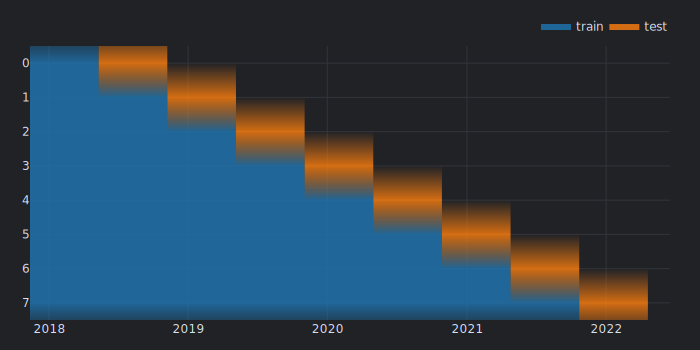

In [197]:
cv = vbt.SplitterCV(
    "from_expanding", 
    min_length=360, 
    offset=180, 
    split=-180,
    set_labels=["train", "test"]
)

cv_splitter = cv.get_splitter(X)
cv_splitter.plot().show_svg()

In [198]:
from sklearn.model_selection import cross_val_score

cross_val_score(clf, X, y, cv=cv, scoring="accuracy")

array([1.        , 0.20555556, 0.88888889, 0.74444444, 1.        ,
       0.93333333, 0.68888889, 0.35555556])

In [199]:
X_slices = cv_splitter.take(X)
y_slices = cv_splitter.take(y)

In [200]:
test_labels = []
test_preds = []
for split in X_slices.index.unique(level="split"):
    X_train_slice = X_slices[(split, "train")]
    y_train_slice = y_slices[(split, "train")]
    X_test_slice = X_slices[(split, "test")]
    y_test_slice = y_slices[(split, "test")]
    slice_clf = clf.fit(X_train_slice, y_train_slice)
    test_pred = slice_clf.predict(X_test_slice)
    test_pred = pd.Series(test_pred, index=y_test_slice.index)
    test_labels.append(y_test_slice)
    test_preds.append(test_pred)
    
test_labels = pd.concat(test_labels).rename("labels")
test_preds = pd.concat(test_preds).rename("preds")

/home/jupyter/miniconda3/envs/vectorbtpro/lib/python3.10/site-packages/jupyter_client/session.py:721: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant



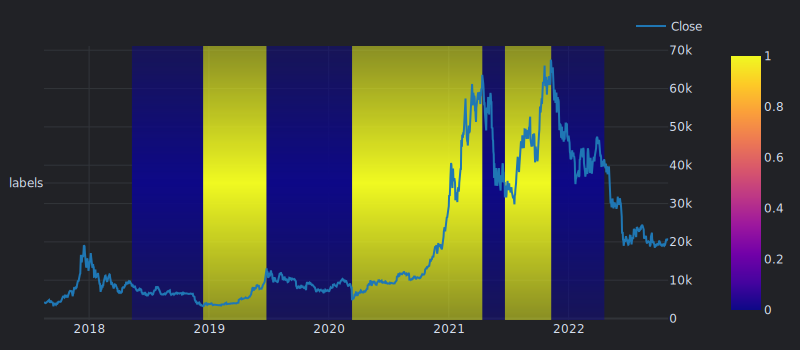

In [201]:
data.close.vbt.overlay_with_heatmap(test_labels).show_svg()

/home/jupyter/miniconda3/envs/vectorbtpro/lib/python3.10/site-packages/jupyter_client/session.py:721: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant



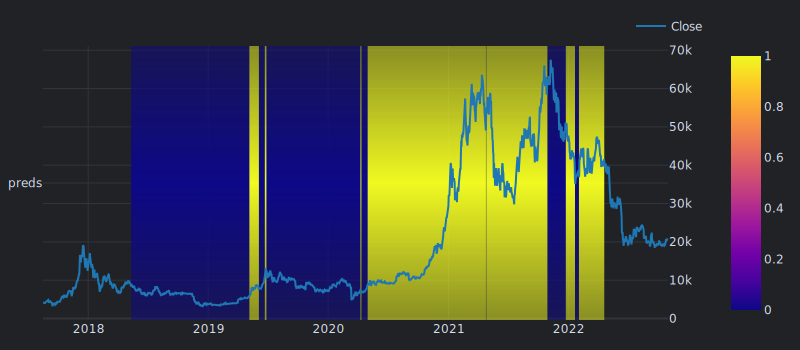

In [202]:
data.close.vbt.overlay_with_heatmap(test_preds).show_svg()

In [203]:
pf = vbt.Portfolio.from_signals(
    data.close[test_preds.index], 
    test_preds == 1, 
    test_preds == 0, 
    direction="both"
)
pf.stats()

Start Index                     2018-05-12 00:00:00+00:00
End Index                       2022-04-20 00:00:00+00:00
Total Duration                         1440 days 00:00:00
Start Value                                         100.0
Min Value                                       86.523425
Max Value                                       755.29421
End Value                                      515.368825
Total Return [%]                               415.368825
Benchmark Return [%]                           388.524488
Position Coverage [%]                               100.0
Max Gross Exposure [%]                          222.44221
Max Drawdown [%]                                55.882136
Max Drawdown Duration                   553 days 00:00:00
Total Orders                                           16
Total Fees Paid                                       0.0
Total Trades                                           16
Win Rate [%]                                    46.666667
Best Trade [%]